### A heatmap demonstaration & test

In [1394]:
%R import::here(gene_set_heatmap, .from='plots/differential_expression.R')

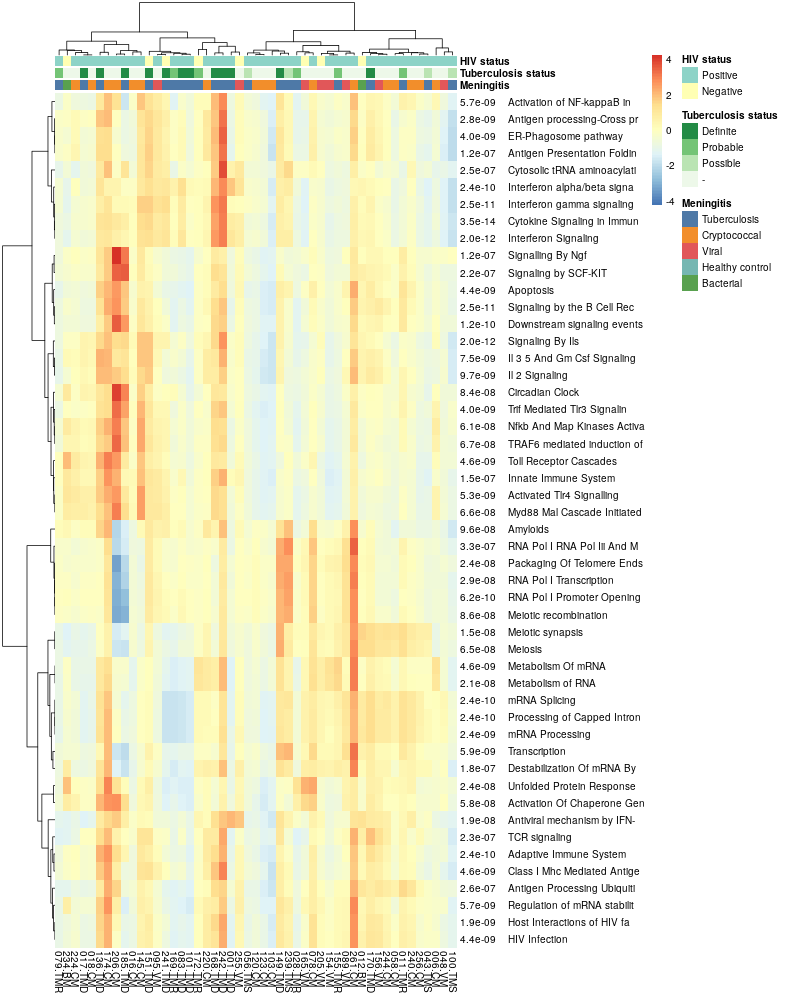

In [193]:
%%R -w 800 -h 1000
gene_set_heatmap(
    head(sets_reactome_entrez, 50), tmm_normalized_tb_subsets,
    collection=c2.cp.reactome, id_type='entrez'
)

Note: changing dynamics of the meiosis/apoptosis cannot be observed in the study which looks at the participants in a single time-point...

But maybe I could look at the participants survival, and some proxy for disease stage and it's relation to the general meiosis/apoptosis balance... TODO?

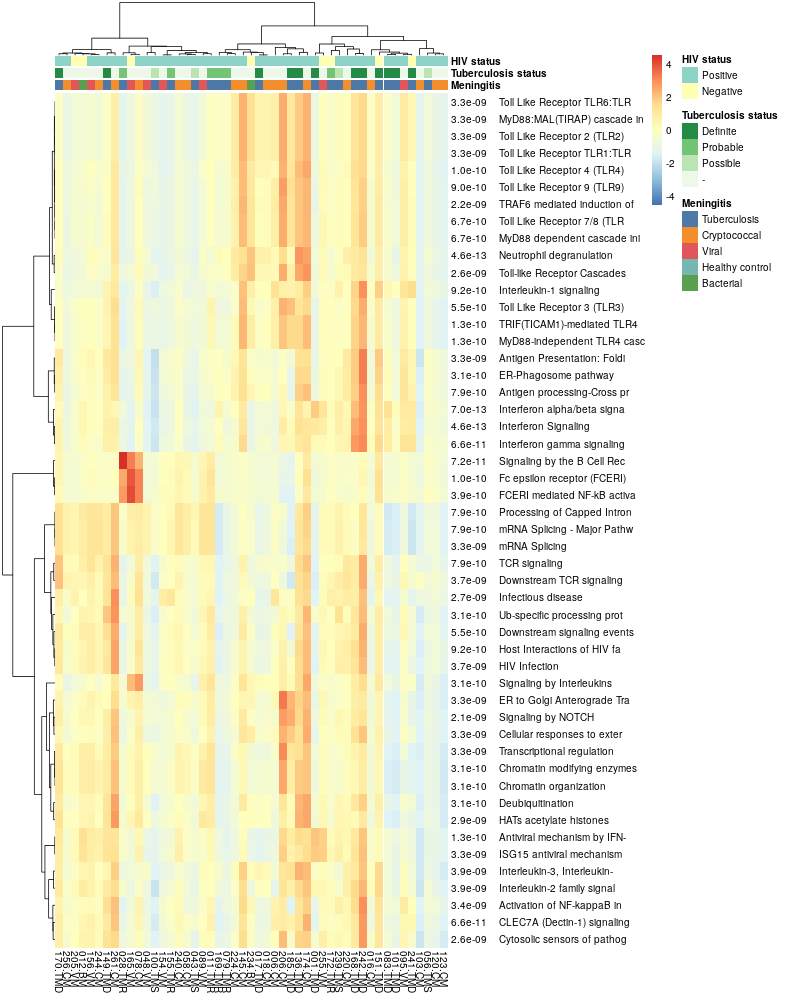

In [194]:
%%R -w 800 -h 1000
gene_set_heatmap(
    head(sets_reactome_symbols, 50), tmm_normalized_tb_subsets,
    collection=reactome_new_symbol, id_type='symbol'
)

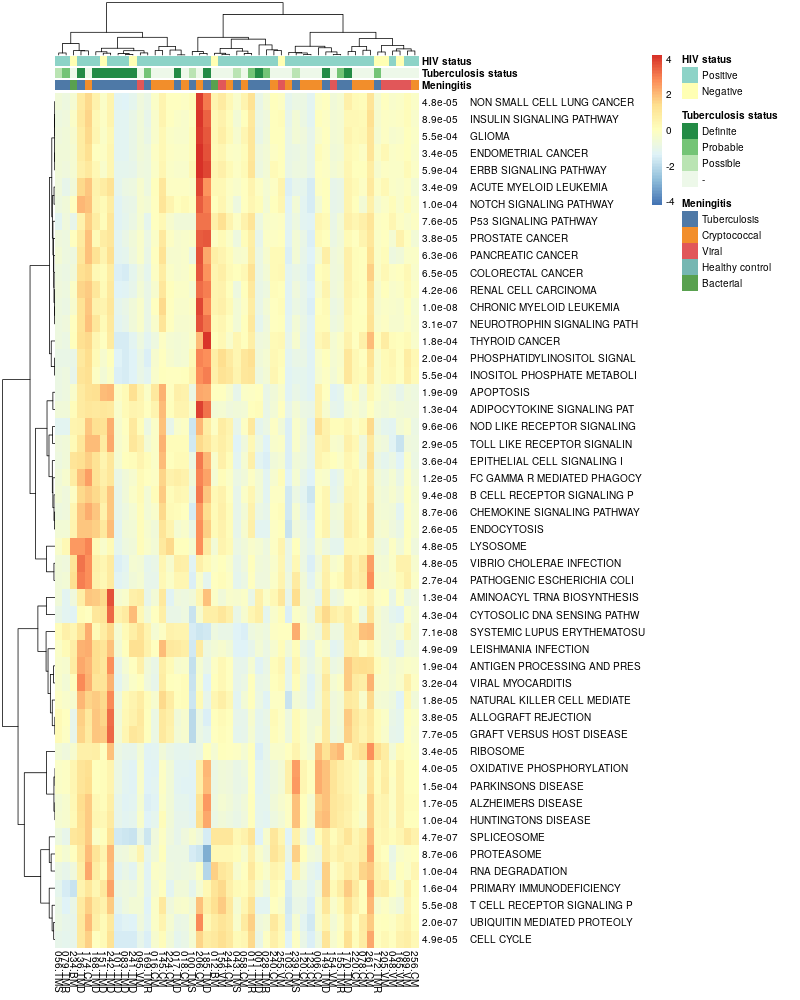

In [195]:
%%R -w 800 -h 1000
gene_set_heatmap(
    head(sets_kegg_entrez, 50), tmm_normalized_tb_subsets,
    collection=c2.cp.kegg, id_type='entrez'
)

It could be tempting to say that KEGG gives the best clustering, but it is wrong:
 - KEGG collection has a small selection of hand-picked pathways; on the plot above I captured more than half (50/94) of significant pathways, but for Reactome I capture only 50/400.
 - we would be testing more hypotheses than needed if we looked at the patients clustering... unless we look at clustering of other groups ;)

Using comparable significance cutoff and k-means sub clustering for Reactome pathways gives us:

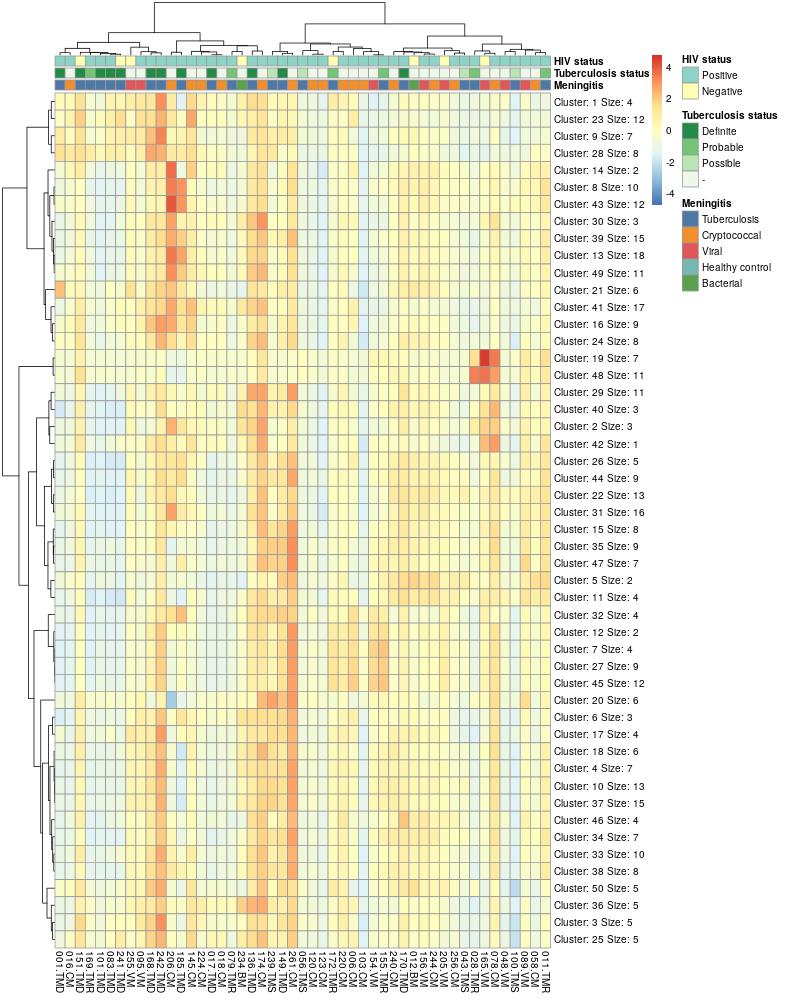

In [196]:
%%R -w 800 -h 1000
gene_set_heatmap(
    sets_reactome_symbols[sets_reactome_symbols$FDR < 1e-04,], tmm_normalized_tb_subsets,
    collection=reactome_new_symbol, id_type='symbol',
    kmeans_k=50, trim=100
)

In [197]:
%%R -w 800 -h 1000
# this is very similar, hidden for brevity
#gene_set_heatmap(
#    sets_reactome_entrez[sets_reactome_entrez$FDR < 1e-04,], tmm_normalized_tb_subsets,
#    collection=c2.cp.reactome, id_type='entrez',
#    kmeans_k=50, trim=100
#)

NULL


### Including topology for pathways analysis

Goals / ideal algorithm:
1. take all significant pathways
2. perform hierarchical clustering
3. choose optimal number of clusters
4. for each cluster:
  - validate that all the pathways have the same direction
  - highlight pathways with the lowest p-value
  - maybe pathways with the highest average expression
  - try to build a pathways hierarchy using the genes information
    E.g. Signaling > Interferon Signaling > **Interferon Gamma Signaling**

In [1880]:
%%R
import::here(counts_to_pathways_space, .from='helpers/pathways.R')
import::here(names_for_pathway_clusters, collapse_count_clusters, .from='helpers/pathways.R')

In [198]:
%%R
pathways_counts = counts_to_pathways_space(tmm_normalized_tb_subsets, collection=c2.cp.reactome, id_type='entrez')

In [199]:
%%R
significant_pathways = sets_reactome_entrez[sets_reactome_entrez$FDR < 0.05,]
significant_counts = pathways_counts[rownames(significant_pathways),]
significant_counts = log2(significant_counts + 0.25)

Creating a temporary cluster...done:
socket cluster with 7 nodes on host ‘localhost’
Multiscale bootstrap... Done.


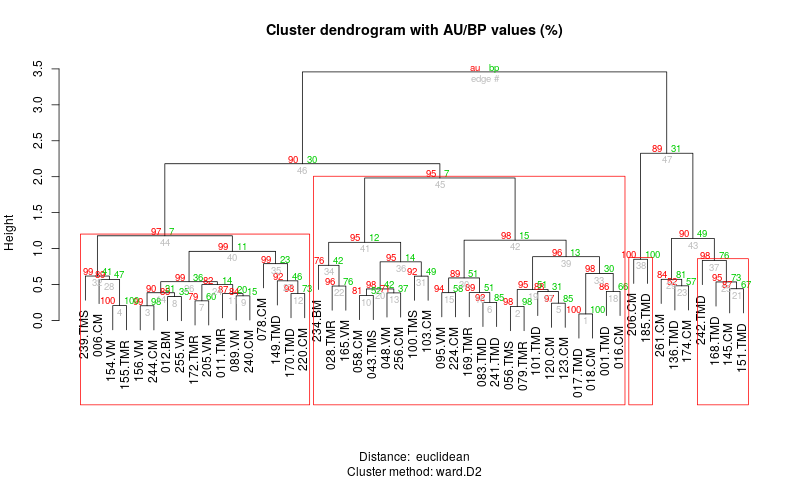

In [200]:
%%R -w 800
set.seed(0)

bootstrapped_clustering <- pvclust::pvclust(
    significant_counts, parallel=T,
    method.hclust="ward.D2", method.dist="euclidean"
)
plot(bootstrapped_clustering)
pvclust::pvrect(bootstrapped_clustering, alpha=0.95)

In [201]:
%%R -w 3000 -h 1200
set.seed(0)
bootstrapped_clustering <- pvclust::pvclust(
    t(significant_counts), parallel=T,
    method.hclust="average", method.dist="correlation",
    nboot=100
)

Creating a temporary cluster...done:
socket cluster with 7 nodes on host ‘localhost’
Multiscale bootstrap... Done.


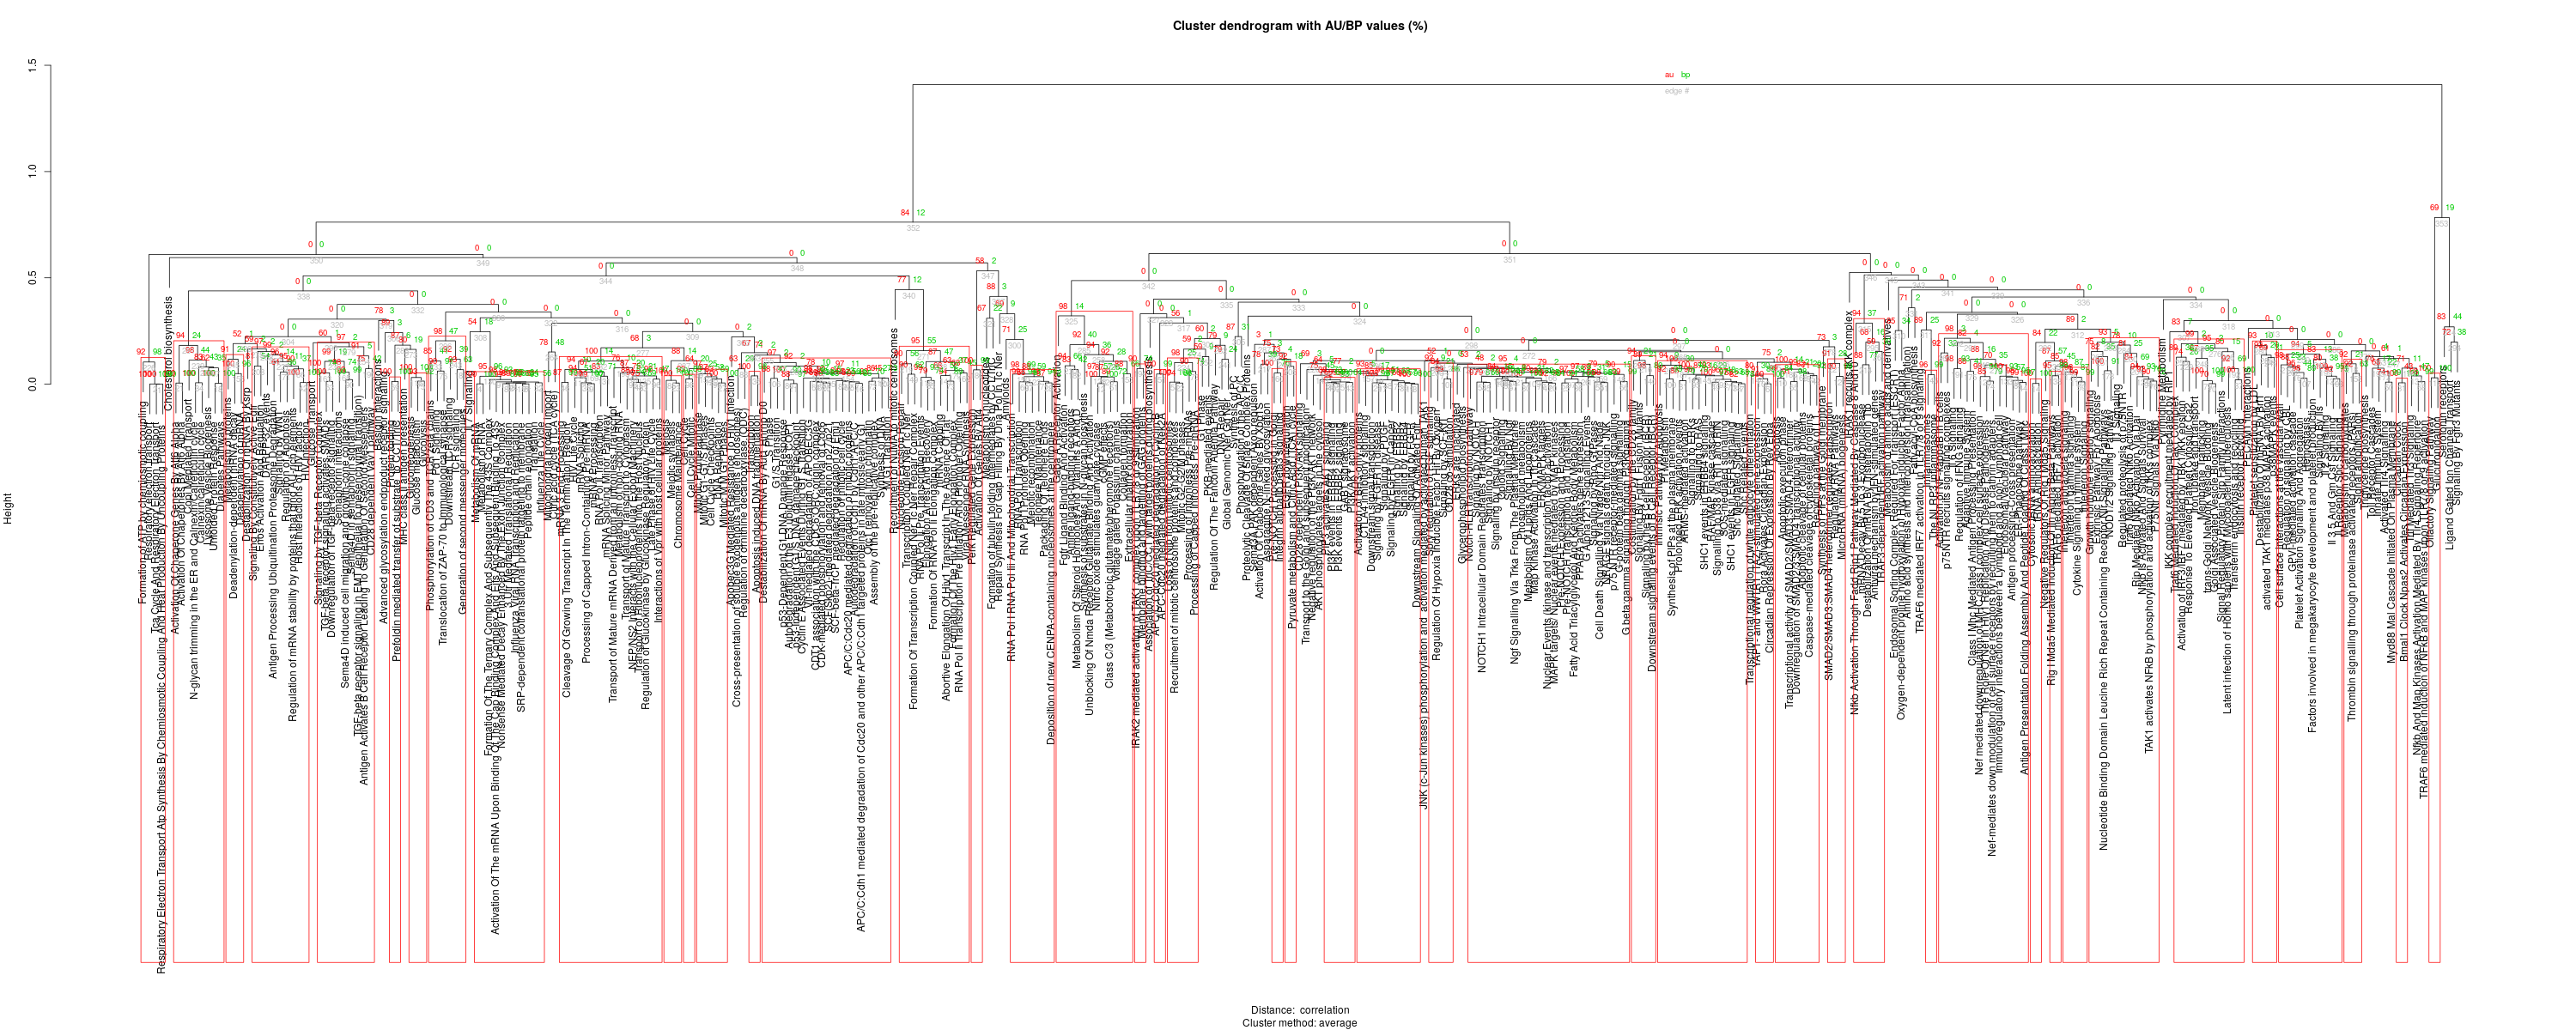

In [202]:
%%R -w 3000 -h 1200
plot(bootstrapped_clustering)
pvclust::pvrect(bootstrapped_clustering, alpha=0.90)

In [203]:
%%R
highly_probable_clusters <- pvclust::pvpick(bootstrapped_clustering, alpha=0.9)

In [204]:
%%R
length(highly_probable_clusters$clusters)

[1] 46


In [205]:
%%R
tb_clusters = Filter(function(pathways) {
    any('Latent infection of Homo sapiens with Mycobacterium tuberculosis' %in% pathways)
}, highly_probable_clusters$clusters)
tb_clusters

[[1]]
 [1] "Membrane Trafficking"                                            
 [2] "trans-Golgi Network Vesicle Budding"                             
 [3] "Signal Regulatory Protein Sirp Family Interactions"              
 [4] "Golgi Associated Vesicle Biogenesis"                             
 [5] "Latent infection of Homo sapiens with Mycobacterium tuberculosis"
 [6] "Activation of IRF3/IRF7 mediated by TBK1/IKK epsilon"            
 [7] "Transferrin endocytosis and recycling"                           
 [8] "Insulin receptor recycling"                                      
 [9] "Traf6 Mediated Induction Of Tak1 Complex"                        
[10] "Iron uptake and transport"                                       
[11] "Response To Elevated Platelet Cytosolic Ca2 "                    



In [206]:
%%R
head(sets_reactome_entrez)

                                                     NGenes Direction
Cytokine Signaling in Immune system                     253        Up
Interferon Signaling                                    146        Up
Signaling By Ils                                        103        Up
Interferon gamma signaling                               58        Up
Signaling by the B Cell Receptor (BCR)                  118        Up
Downstream signaling events of B Cell Receptor (BCR)     90        Up
                                                           PValue          FDR
Cytokine Signaling in Immune system                  5.289373e-17 3.549169e-14
Interferon Signaling                                 6.908348e-15 2.028852e-12
Signaling By Ils                                     9.070874e-15 2.028852e-12
Interferon gamma signaling                           1.612464e-13 2.508075e-11
Signaling by the B Cell Receptor (BCR)               1.868908e-13 2.508075e-11
Downstream signaling events of B Cel

In [207]:
%%R
cluster_names = names_for_pathway_clusters(highly_probable_clusters$clusters, pathways_data=c2.cp.reactome, pathways_ranking=sets_reactome_entrez)
counts_collapsed = collapse_count_clusters(significant_counts, clusters=highly_probable_clusters$clusters, names=cluster_names)

[1] "Warning: parent node PI3K events in ERBB2 signaling will not be displayed"
[1] "[GAB1 signalosome | PI3K/AKT activation | PI3K events in ERBB4 signaling]"
[2] "PIP3 activates AKT signaling"                                             
[1] "Warning: parent node Signalling By Ngf will not be displayed"                   
[2] "Warning: parent node Map Kinase Activation In Tlr Cascade will not be displayed"
[[1]]
[1] "[Ngf Signalling Via Trka From The Plasma Membrane | MAPK targets/ Nuclear events mediated by MAP kinases]"

[[2]]
[1] "Nuclear Events (kinase and transcription factor activation)"

[[3]]
[1] "ERK/MAPK targets"

[1] "Warning: parent node Signalling By Ngf will not be displayed"
[1] "[Map Kinase Activation In Tlr Cascade | Ngf Signalling Via Trka From The Plasma Membrane]"
[2] "Nuclear Events (kinase and transcription factor activation)"                              
[1] "Warning: parent node Signalling to ERKs will not be displayed"             
[2] "Warning: parent node 

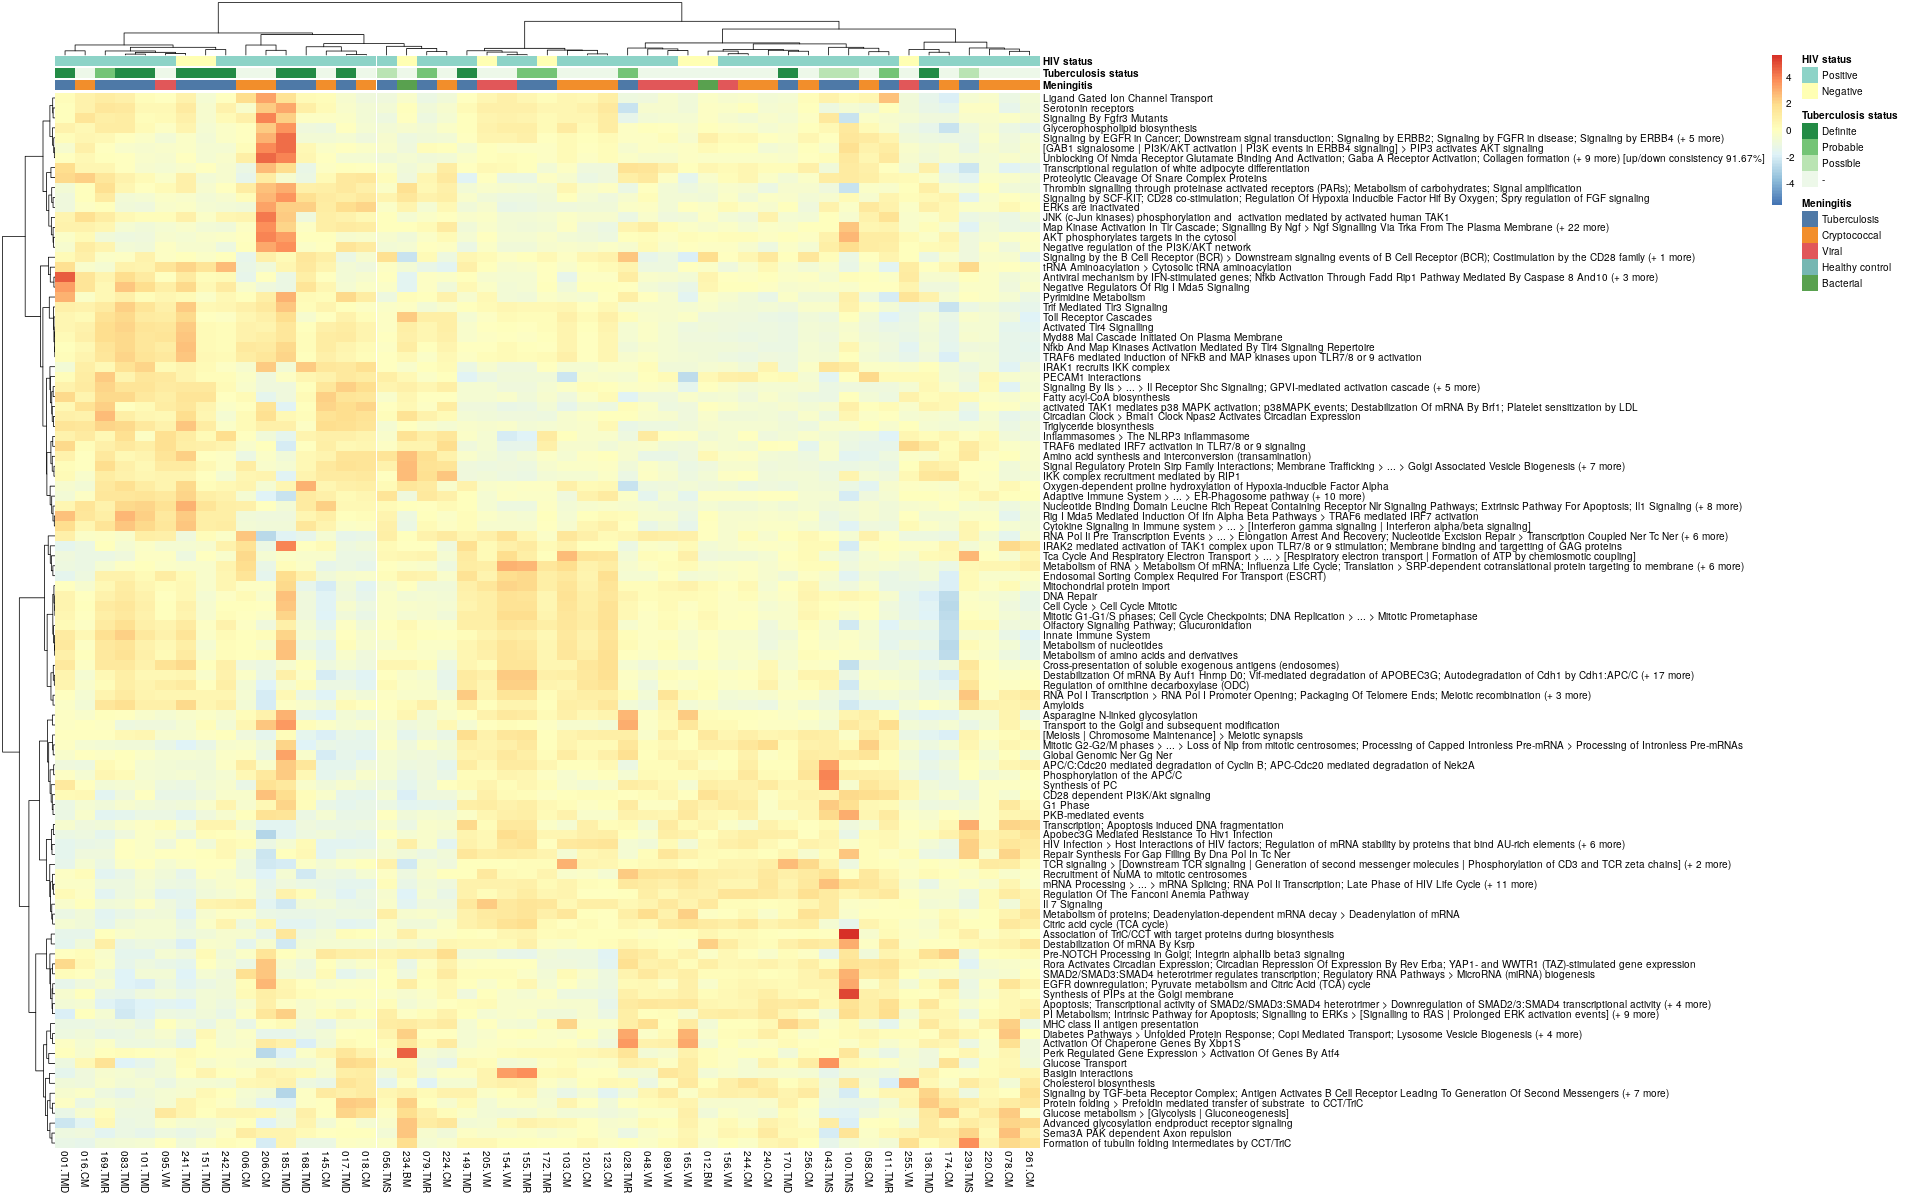

In [208]:
%%R -w 1920 -h 1200
pheatmap(
    scale(counts_collapsed),
    show_colnames=T,
    show_rownames=T,
    annotation_col=counts_patient_annotations,
    annotation_colors=patient_colors,
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    cluster_rows=T,
    cluster_cols=T,
    scale='row',
    clustering_distance_rows='correlation'
)

- TODO: place that into the function as debugg/verbose:!!!!!
- TODO: make a heatmap with results for both proteomics and transcriptomics data

### Some heatmaps for DESeq2 and Voom: with & without filtering

In [1420]:
voom_weighted_tmm = definite_tb_cm_limma_cmp_weighted['voom_tmm']
voom_simple_tmm = definite_tb_cm_cmp['voom_tmm']

voom_weighted_rle = definite_tb_cm_limma_cmp_weighted['voom_rle']
voom_simple_rle = definite_tb_cm_cmp['voom_rle']

voom_weighted_eee = definite_tb_cm_limma_cmp_weighted['voom_eee']
voom_simple_eee = definite_tb_cm_cmp['voom_eee']
voom_filtered_eee = definite_tb_cm_limma_cmp_filtered['voom_eee']

voom_simple_qtotal = definite_tb_cm_cmp['voom_qtotal']
voom_weighted_qtotal = definite_tb_cm_limma_cmp_weighted['voom_qtotal']
voom_filtered_qtotal = definite_tb_cm_limma_cmp_filtered['voom_qtotal']

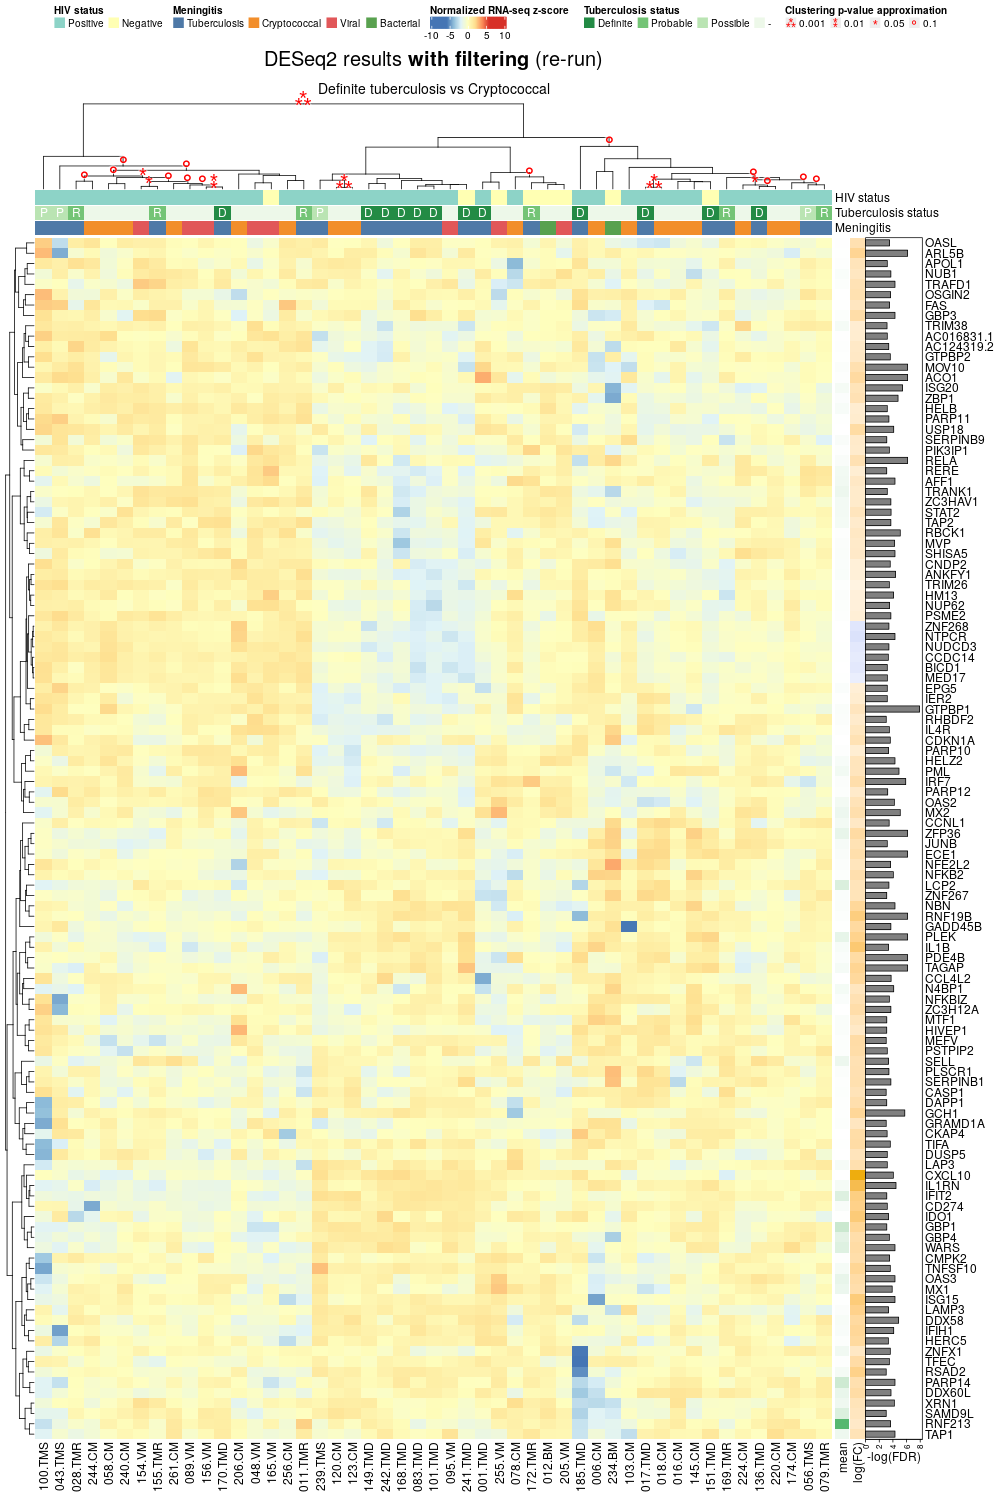

In [1827]:
%%R -w 1000 -h 1500
de_heatmap(
    significant.deseq(deseq2_with_filtering), dds_edger_prefiltered,
    major='DESeq2 results \\textbf{with filtering} (re-run)',
    minor='Definite tuberculosis vs Cryptococcal'
)

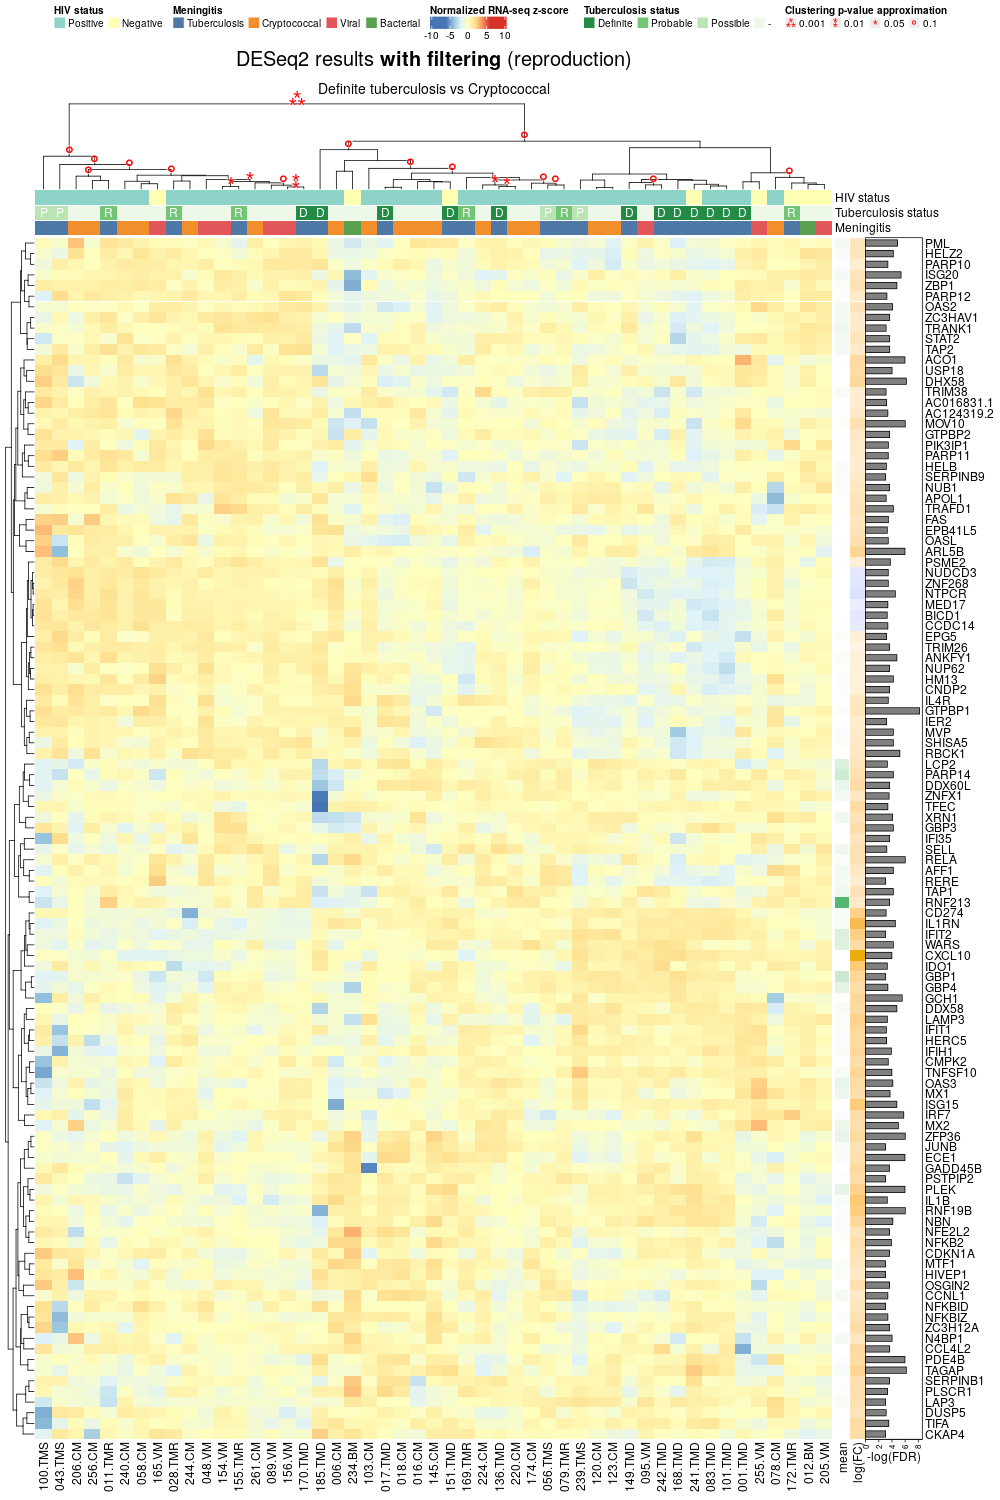

In [1829]:
%%R -w 1000 -h 1500
de_heatmap(
    significant.deseq(deseq2_with_filtering_reproduction), dds_reproduction,
    major='DESeq2 results \\textbf{with filtering} (reproduction)',
    minor='Definite tuberculosis vs Cryptococcal'
)

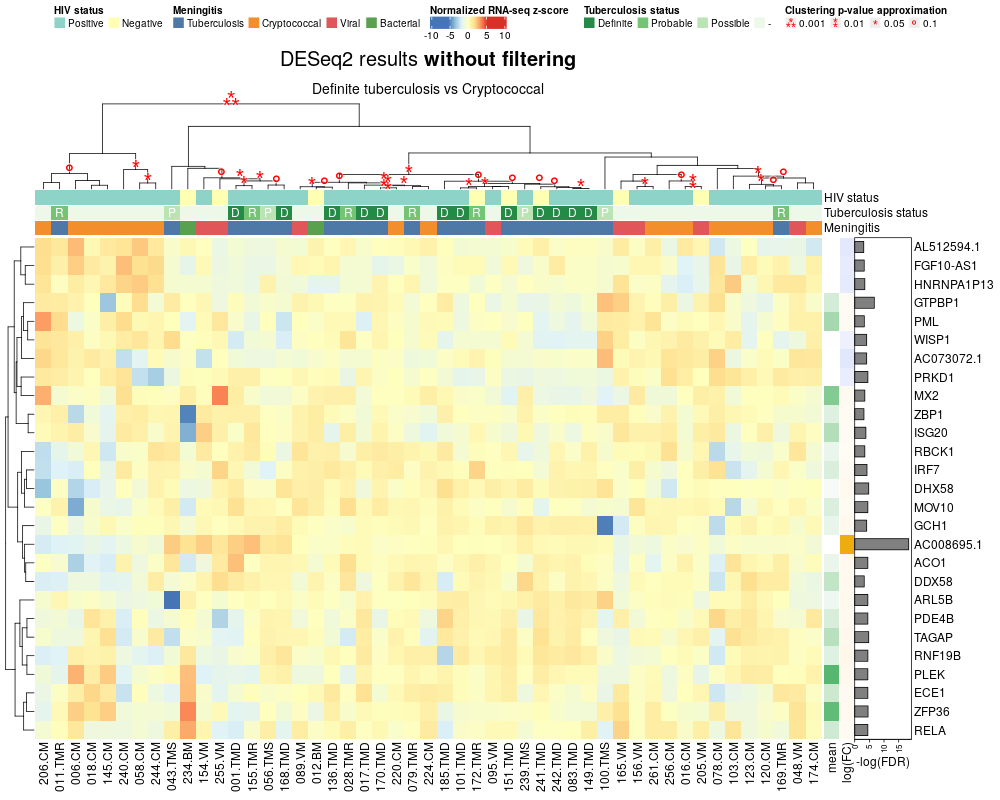

In [1831]:
%%R -w 1000 -h 800
de_heatmap(
    significant.deseq(deseq2_without_filtering), dds_edger_prefiltered,
    major='DESeq2 results \\textbf{without filtering}',
    minor='Definite tuberculosis vs Cryptococcal'
)

AC008695.1 has a very consistent signal (very high logFC).

It is uncharacterized, but similar to RAPGEF6, which may play a role in cell-cell junctions formation:
https://www.sciencedirect.com/science/article/pii/S0898656808001459, Also something about Rap1 isoforms signaling.

How does it compare to voom results?

In [1869]:
with_gene_data(voom_simple_rle).query("gene_name in ['RAPGEF6', 'AC008695.1']")

logFC   AveExpr         t   P.Value  adj.P.Val         B  \
ENSG00000158987 -0.119254  7.123293 -0.800150  0.426852   0.913804 -5.916807   
ENSG00000273217  0.555357 -1.560686  0.483387  0.630851   0.950252 -4.950990   

                  gene_name         biotype contig strand  
ENSG00000158987     RAPGEF6  protein_coding      5      -  
ENSG00000273217  AC008695.1  protein_coding      5      -

In [1855]:
with_gene_data(voom_simple_tmm).query("gene_name in ['RAPGEF6', 'AC008695.1']")

logFC   AveExpr         t   P.Value  adj.P.Val         B  \
ENSG00000158987  0.231149  7.123293  0.846757  0.400265   0.776569 -5.755939   
ENSG00000273217  0.827811 -1.560686  0.746082  0.459374   0.807697 -5.164359   

                  gene_name         biotype contig strand  
ENSG00000158987     RAPGEF6  protein_coding      5      -  
ENSG00000273217  AC008695.1  protein_coding      5      -

In [1859]:
with_gene_data(deseq2_without_filtering, sort=F).query("gene_name in ['RAPGEF6', 'AC008695.1']")

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
ENSG00000158987  466.048853       -0.080817  0.177202 -0.456071  6.483391e-01   
ENSG00000273217   14.612156       23.771445  3.261043  7.289521  3.110580e-13   

                         padj   gene_name         biotype contig strand  
ENSG00000158987  9.999882e-01     RAPGEF6  protein_coding      5      -  
ENSG00000273217  9.956968e-09  AC008695.1  protein_coding      5      -

In [612]:
with_gene_data(deseq2_with_filtering_normal, sort=F).query("gene_name in ['RAPGEF6', 'AC008695.1']")

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
ENSG00000158987  466.048853       -0.080826  0.161301 -0.456070  6.483395e-01   
ENSG00000273217   14.612156        0.052721  0.136964  6.489305  8.623321e-11   

                    padj   gene_name         biotype contig strand  
ENSG00000158987  0.94354     RAPGEF6  protein_coding      5      -  
ENSG00000273217      NaN  AC008695.1  protein_coding      5      -

In [614]:
with_gene_data(deseq2_with_filtering_apeglm, sort=F).query("gene_name in ['RAPGEF6', 'AC008695.1']")

baseMean  log2FoldChange     lfcSE        pvalue     padj  \
ENSG00000158987  466.048853       -0.025979  0.096964  6.483395e-01  0.94354   
ENSG00000273217   14.612156        0.004110  0.111370  8.623321e-11      NaN   

                  gene_name         biotype contig strand  
ENSG00000158987     RAPGEF6  protein_coding      5      -  
ENSG00000273217  AC008695.1  protein_coding      5      -

In [616]:
with_gene_data(deseq2_with_filtering_ashr, sort=F).query("gene_name in ['RAPGEF6', 'AC008695.1']")

baseMean  log2FoldChange     lfcSE        pvalue     padj  \
ENSG00000158987  466.048853       -0.011679  0.069350  6.483395e-01  0.94354   
ENSG00000273217   14.612156       20.654679  3.235659  8.623321e-11      NaN   

                  gene_name         biotype contig strand  
ENSG00000158987     RAPGEF6  protein_coding      5      -  
ENSG00000273217  AC008695.1  protein_coding      5      -

Here we go, after shrinkage (except for ashr) it does look so great (NaN in padj is unrelated, the variables were just reused from filtered dds).

**Therefore, downstream analysis after DESEq2 should always check if the logFC remains high after shrinkage**.

Interestingly, the shrunken log-fold changes are now comparable between voom and deseq for the normal shrinkage.

[1] "Too few observations to assess the clustering p-values"


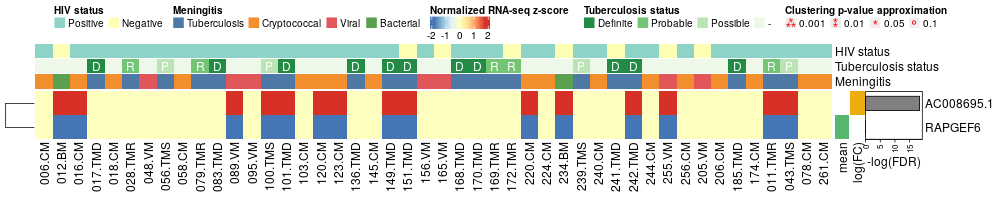

In [1965]:
%%R -w 1000 -h 200
de_heatmap(
    deseq2_without_filtering[c('ENSG00000158987', 'ENSG00000273217'),], dds_edger_prefiltered,
    skip_cols=c('175.TMD', '074.TMS', '093.TMD', '128.TMD', '158.TMD', '167.TMR', '233.CM', '001.TMD', '155.TMR', '154.VM')
)

Maybe there is something with the transcript mapping?

In [1930]:
%%R -o dds_counts
dds_counts = as.data.frame(counts(dds_edger_prefiltered, normalized=T))

In [1910]:
show_table(
    raw_counts_matrix.loc[['ENSG00000158987', 'ENSG00000273217']].T
    .query("ENSG00000158987 != 0 or ENSG00000273217 != 0")
)

ENSG00000158987  ENSG00000273217
001.TMD  21.33            21.67          
006.CM   169.00           0.00           
012.BM   795.00           0.00           
016.CM   213.00           0.00           
017.TMD  620.00           0.00           
018.CM   396.00           0.00           
028.TMR  576.00           0.00           
048.VM   2508.00          0.00           
056.TMS  1096.02          25.22          
058.CM   168.00           0.00           
079.TMR  966.00           0.00           
083.TMD  642.00           0.00           
089.VM   869.00           0.00           
093.TMD  217.00           0.00           
095.VM   826.00           0.00           
100.TMS  21.00            0.00           
101.TMD  778.00           0.00           
103.CM   586.00           0.00           
120.CM   583.00           0.00           
123.CM   838.00           0.00           
136.TMD  259.00           0.00           
145.CM   132.00           0.00           
149.TMD  411.00           0.00           
151.TMD  528.00           0.00           
154.VM   478.26           80.74          
155.TMR  1257.86          331.14         
156.VM   9973.00          0.00           
165.VM   444.00           0.00           
168.TMD  162.88           12.43          
170.TMD  690.00           0.00           
169.TMR  237.00           0.00           
172.TMR  1814.00          0.00           
220.CM   1357.00          0.00           
224.CM   576.00           0.00           
234.BM   590.19           58.13          
239.TMS  872.37           14.71          
240.CM   530.00           0.00           
241.TMD  409.00           0.00           
242.TMD  843.00           0.00           
244.CM   629.00           0.00           
255.VM   313.38           51.62          
256.CM   675.00           0.00           
205.VM   843.00           0.00           
206.CM   52.00            0.00           
185.TMD  66.00            0.00           
174.CM   375.00           0.00           
011.TMR  166.00           0.00           
043.TMS  422.01           42.99          
078.CM   961.00           0.00           
261.CM   712.00           0.00

So we got a case of log fold change for a pair where one group has sum of counts = 0

In [1936]:
dds_counts.loc['ENSG00000273217', dds_counts.index.str.endswith('CM')].sum()

0.0

Apparently, DESeq does not handle such cases explicitly if one group in contrast has zeros only. See: https://support.bioconductor.org/p/111231/

**TODO: add a criterion to select only those which have SHRUNKEN abs(log2(FC)) > 1 for DESEq2**.

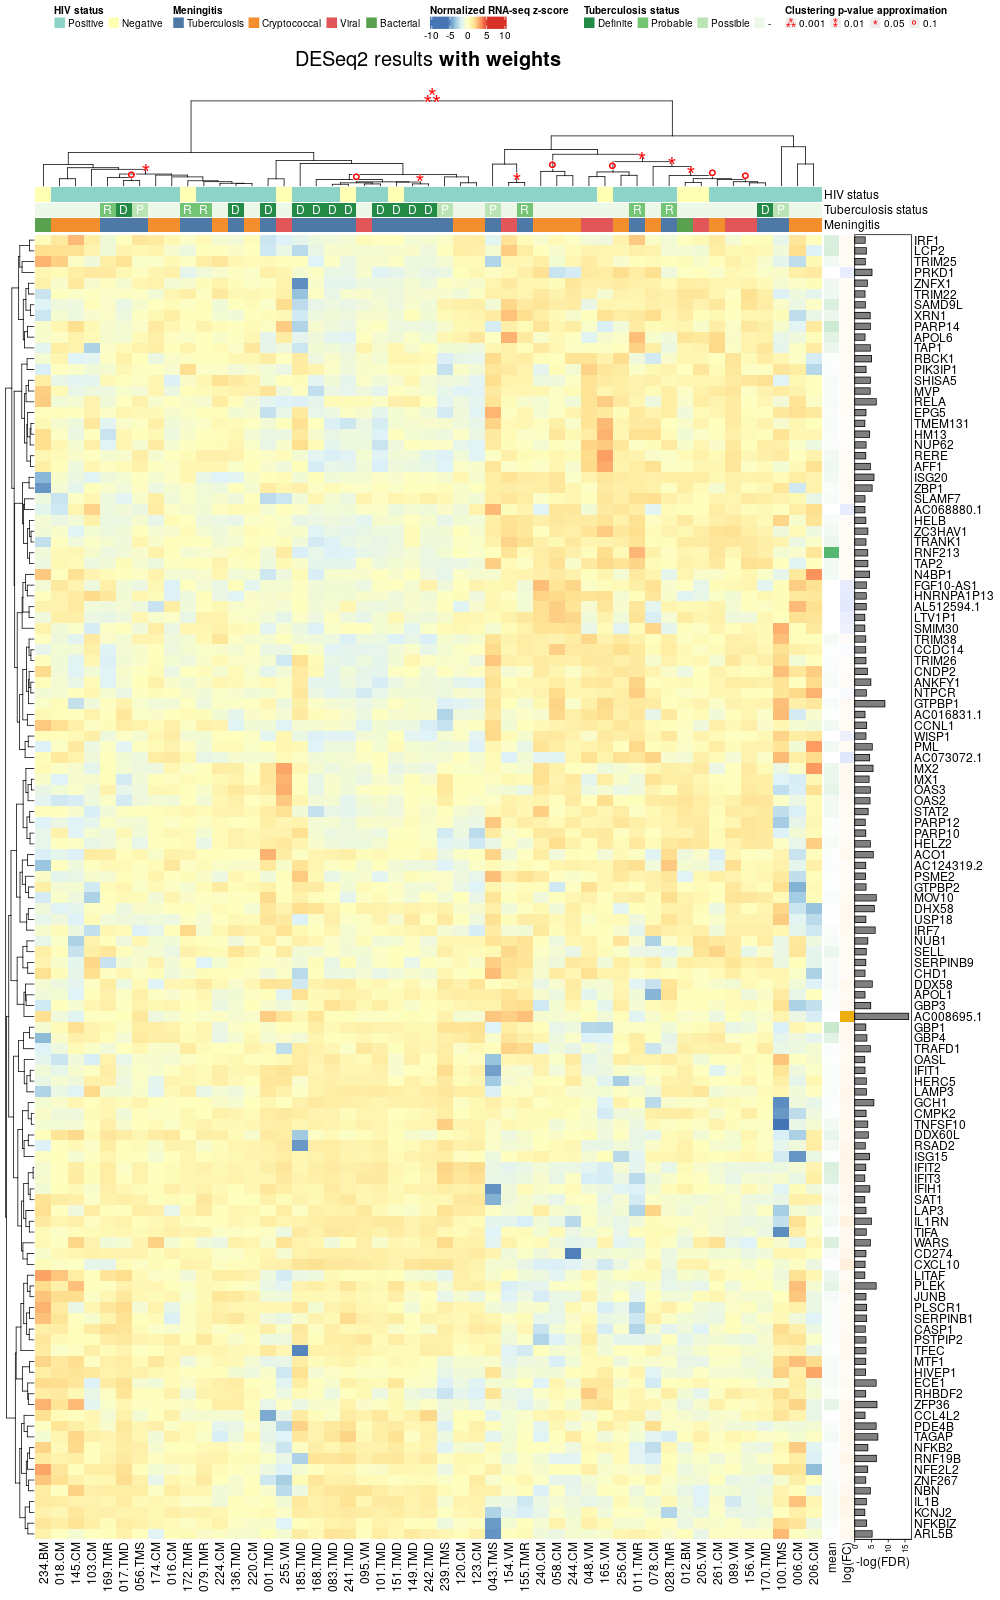

In [1940]:
%%R -w 1000 -h 1600
de_heatmap(
    significant.deseq(deseq2_with_weighting), dds_edger_prefiltered,
    major='DESeq2 results \\textbf{with weights}}',
    minor='Definite tuberculosis vs Cryptococcal'
)

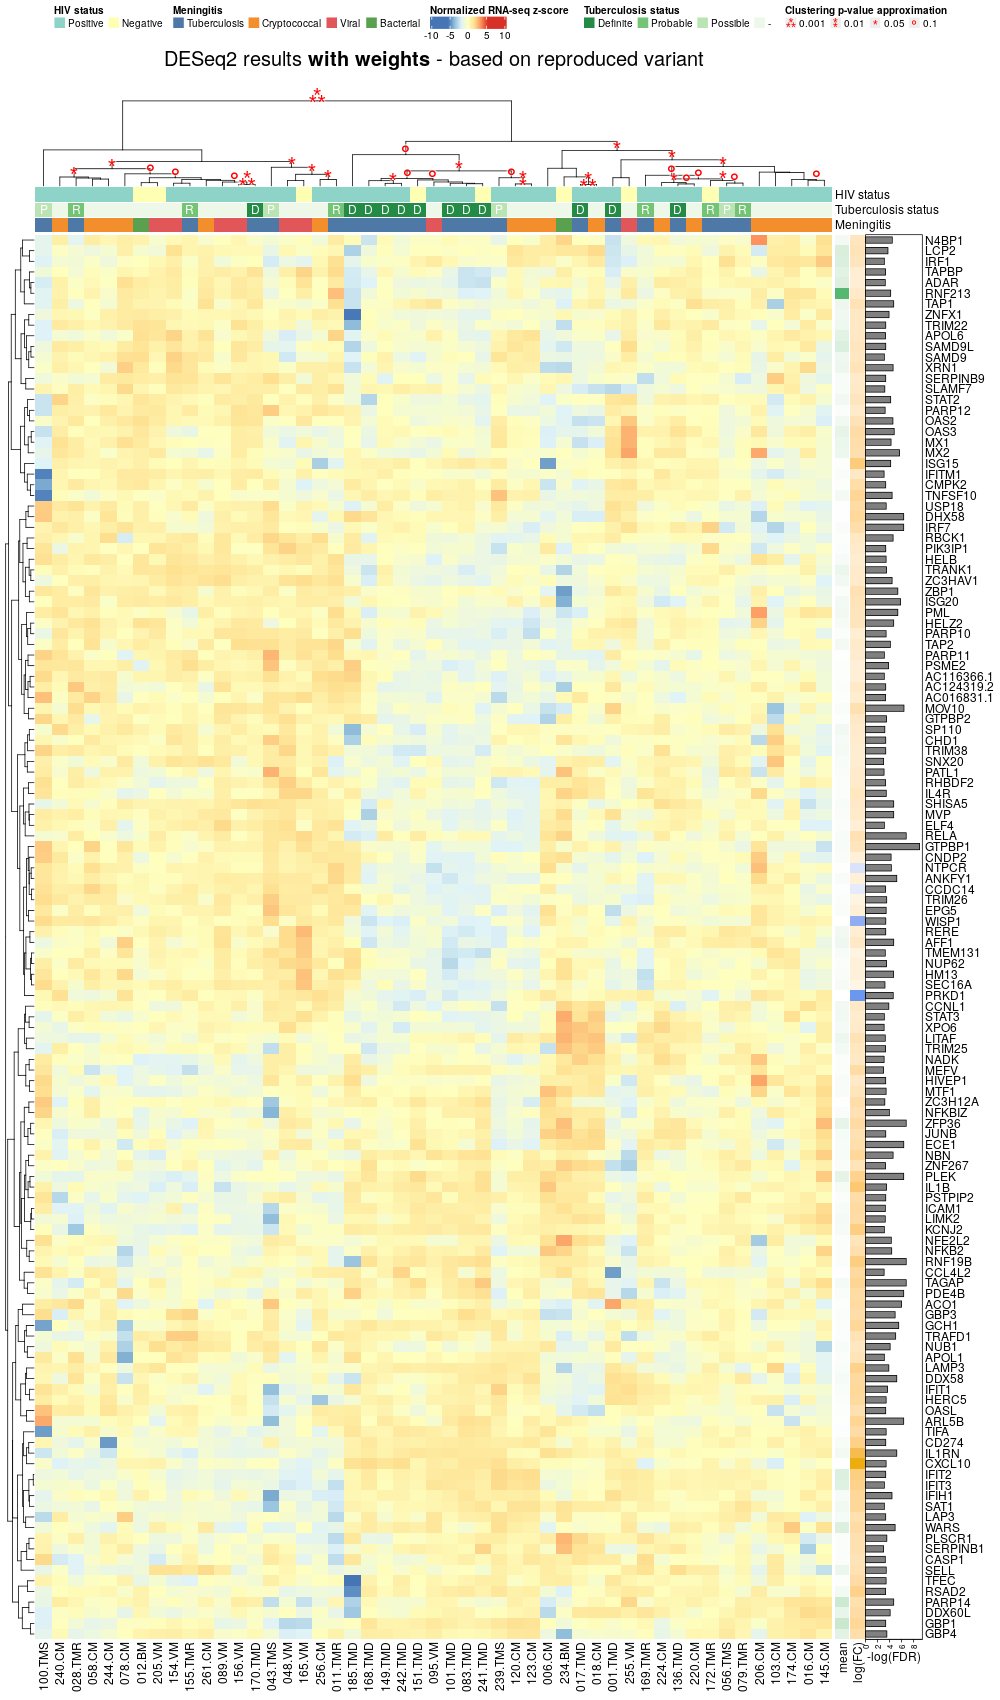

In [1961]:
%%R -w 1000 -h 1700
de_heatmap(
    significant.deseq(deseq2_with_weighting_reproduction), dds_reproduction,
    major='DESeq2 results \\textbf{with weights} - based on reproduced variant}',
    minor='Definite tuberculosis vs Cryptococcal'
)

In [1958]:
with_gene_data(voom_simple_tmm).query("gene_name in ['WISP1', 'AC012363.1', 'RNF213']")

logFC    AveExpr         t       P.Value  adj.P.Val  \
ENSG00000224789  3.561383  -1.218302  6.021654  9.125444e-08   0.001575   
ENSG00000173821  1.142558  11.728214  3.682157  4.750803e-04   0.161419   
ENSG00000104415 -1.760435   1.713906 -3.645468  5.348101e-04   0.162976   

                        B   gene_name         biotype contig strand  
ENSG00000224789  5.470512  AC012363.1       antisense      2      -  
ENSG00000173821 -0.244006      RNF213  protein_coding     17      +  
ENSG00000104415 -0.366549       WISP1  protein_coding      8      +

Individual genes do not agree between methods too much, and if they do I doubt because those are lowly expressed. The heatmap looks nice, but could I get such a nice heatmap from random data?

[1] "Too few observations to assess the clustering p-values"


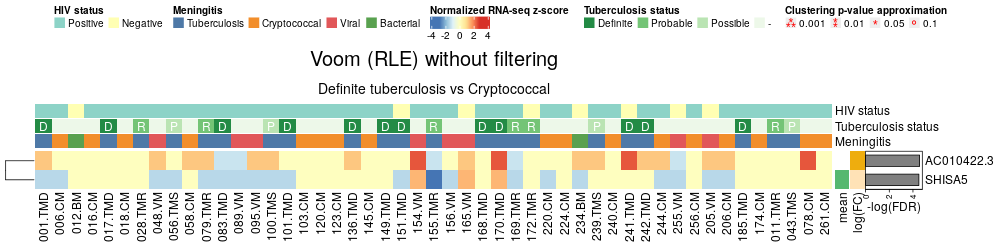

In [467]:
%%R -w 1000 -h 250 -i voom_simple_rle

de_heatmap(
    significant.limma(voom_simple_rle), rle_normalized_tb_subsets,
    major='Voom (RLE) without filtering',
    minor='Definite tuberculosis vs Cryptococcal'
)

Side note: in the previous iteration, a simpler version of the heatmap was used, and it can be accessed with simple_de_heatmap():

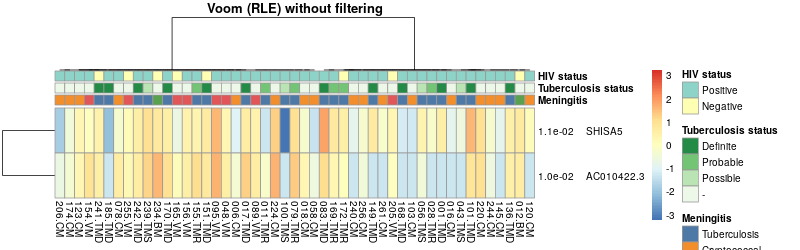

In [453]:
%%R -w 800 -h 250
simple_de_heatmap(
    significant.limma(voom_simple_rle), tmm_normalized_tb_subsets,
    main='Voom (RLE) without filtering'
)

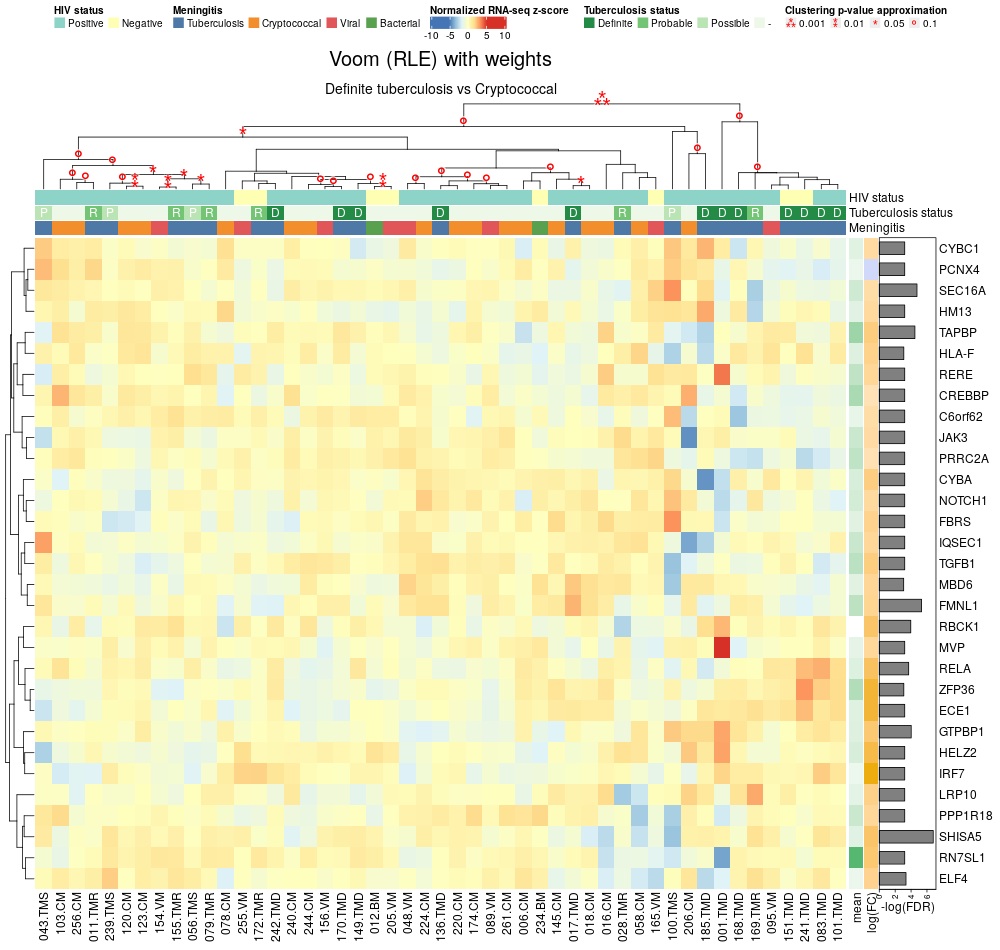

In [469]:
%%R -w 1000 -h 950 -i voom_weighted_rle

de_heatmap(
    significant.limma(voom_weighted_rle), rle_normalized_tb_subsets,
    major='Voom (RLE) with weights',
    minor='Definite tuberculosis vs Cryptococcal'
)

In [1434]:
%R head(as.data.frame(cpm(qtotal_normalized_tb_subsets, log=T)))

001.TMD     006.CM     012.BM     016.CM    017.TMD  ...  \
ENSG00000000003  21.763353  21.042939  20.184175  23.459844  23.047481  ...   
ENSG00000000419  18.902513  22.773932  24.185194  18.902513  24.538807  ...   
ENSG00000000457  25.029903  24.916717  25.388249  24.698441  25.302079  ...   
ENSG00000000460  23.606142  18.902513  24.640008  23.855986  22.368248  ...   
ENSG00000000938  27.014342  27.230913  26.482569  27.610138  29.410123  ...   
ENSG00000000971  18.902513  25.061397  24.158426  22.946862  22.677077  ...   

                    174.CM    011.TMR    043.TMS     078.CM     261.CM  
ENSG00000000003  20.689272  23.750757  23.310186  18.902513  22.918120  
ENSG00000000419  22.818008  21.701227  18.902513  25.595170  23.815839  
ENSG00000000457  25.004068  24.626243  20.601705  24.799739  25.445106  
ENSG00000000460  23.157720  23.689285  23.408584  18.902513  23.456732  
ENSG00000000938  27.001694  25.846705  26.626937  26.647766  26.529356  
ENSG00000000971  19.591899  24.102154  23.204582  23.874511  24.240669  

[6 rows x 49 columns]

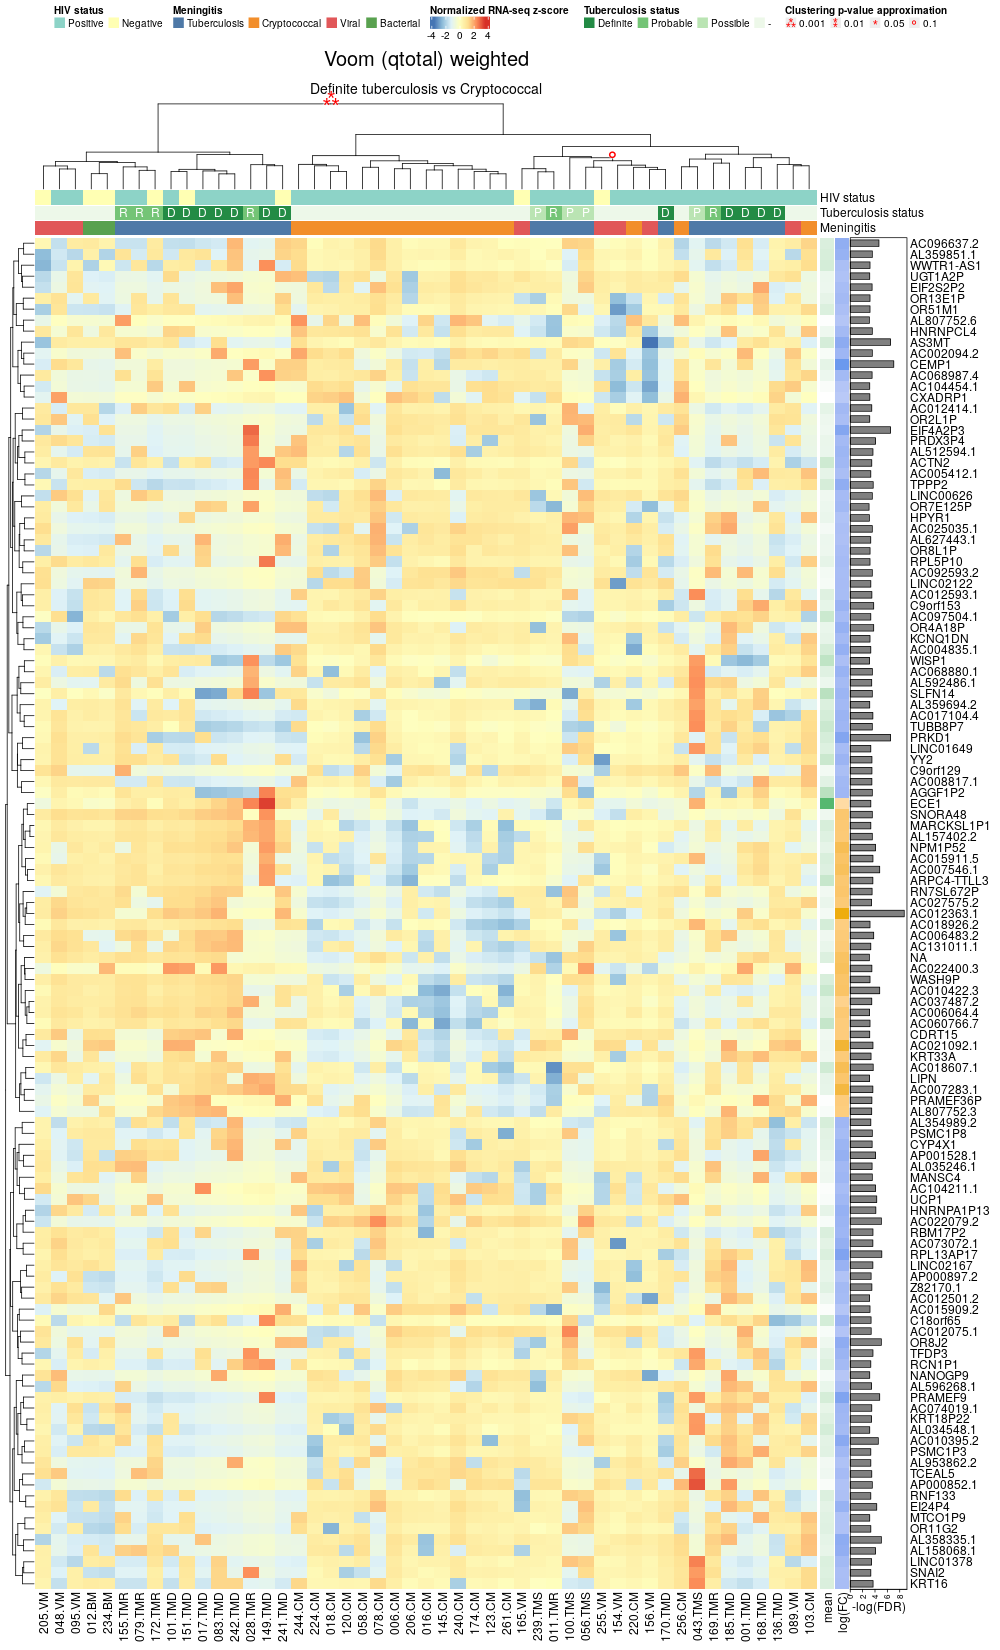

In [1422]:
%%R -w 1000 -h 1650 -i voom_weighted_qtotal

de_heatmap(
    significant.limma(voom_weighted_qtotal), qtotal_normalized_tb_subsets,
    major='Voom (qtotal) weighted',
    minor='Definite tuberculosis vs Cryptococcal'
)

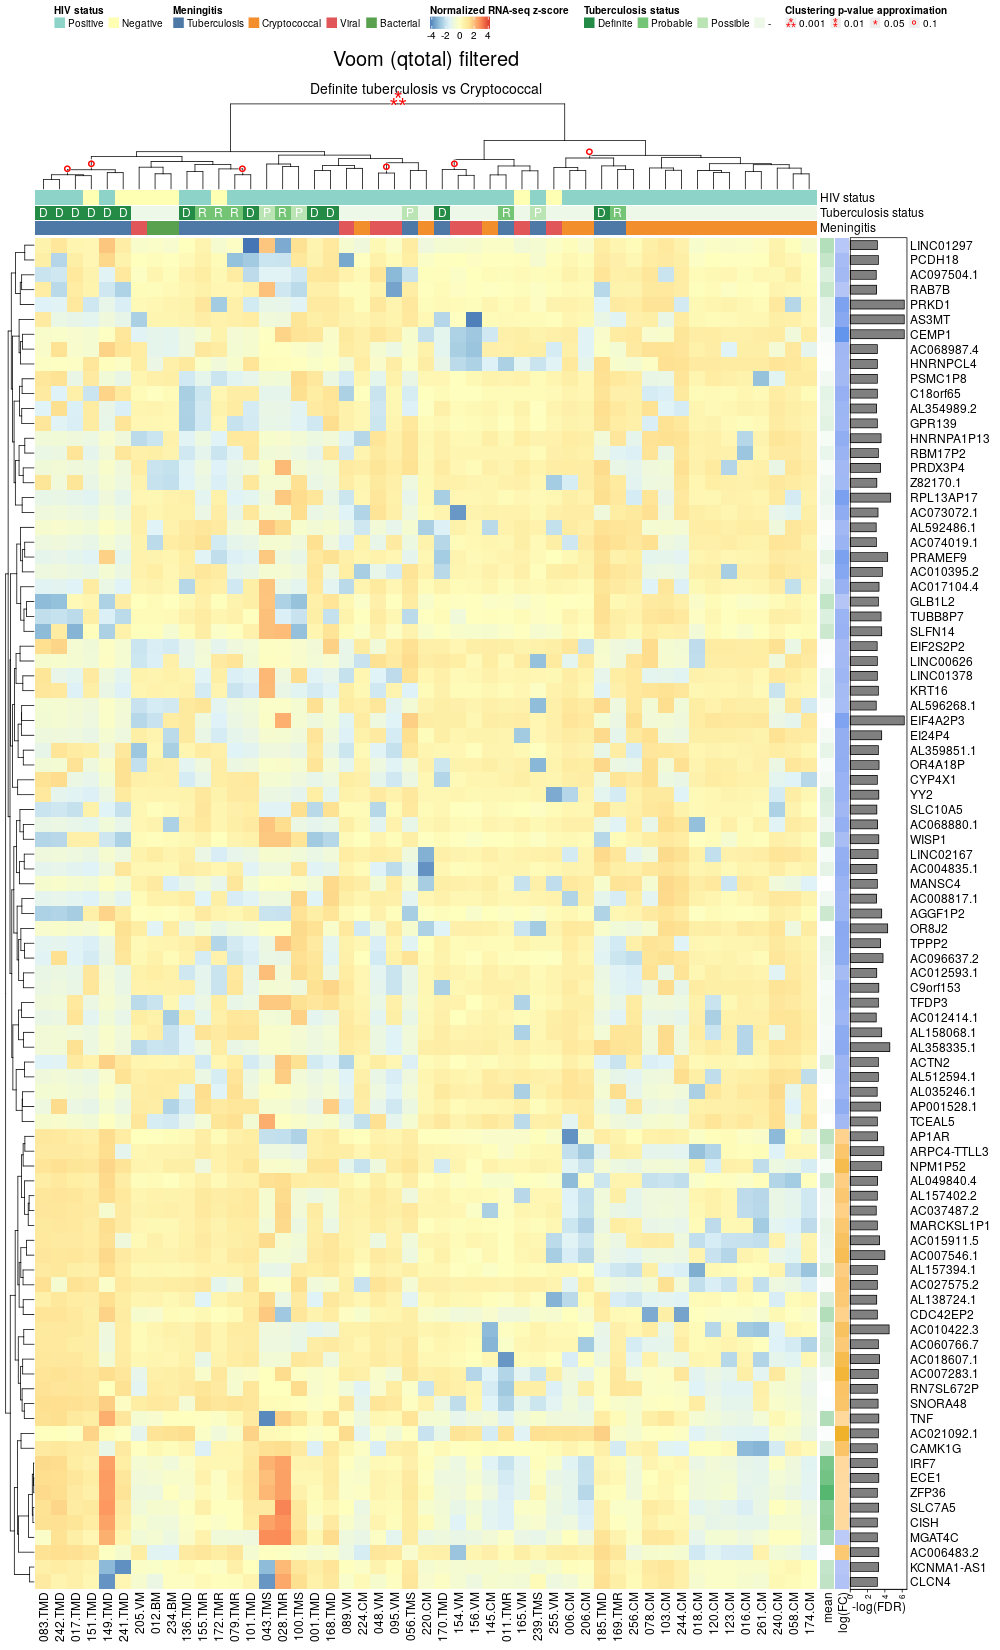

In [1410]:
%%R -w 1000 -h 1650 -i voom_filtered_qtotal

de_heatmap(
    significant.limma(voom_filtered_qtotal), qtotal_normalized_tb_subsets,
    major='Voom (qtotal) filtered',
    minor='Definite tuberculosis vs Cryptococcal'
)

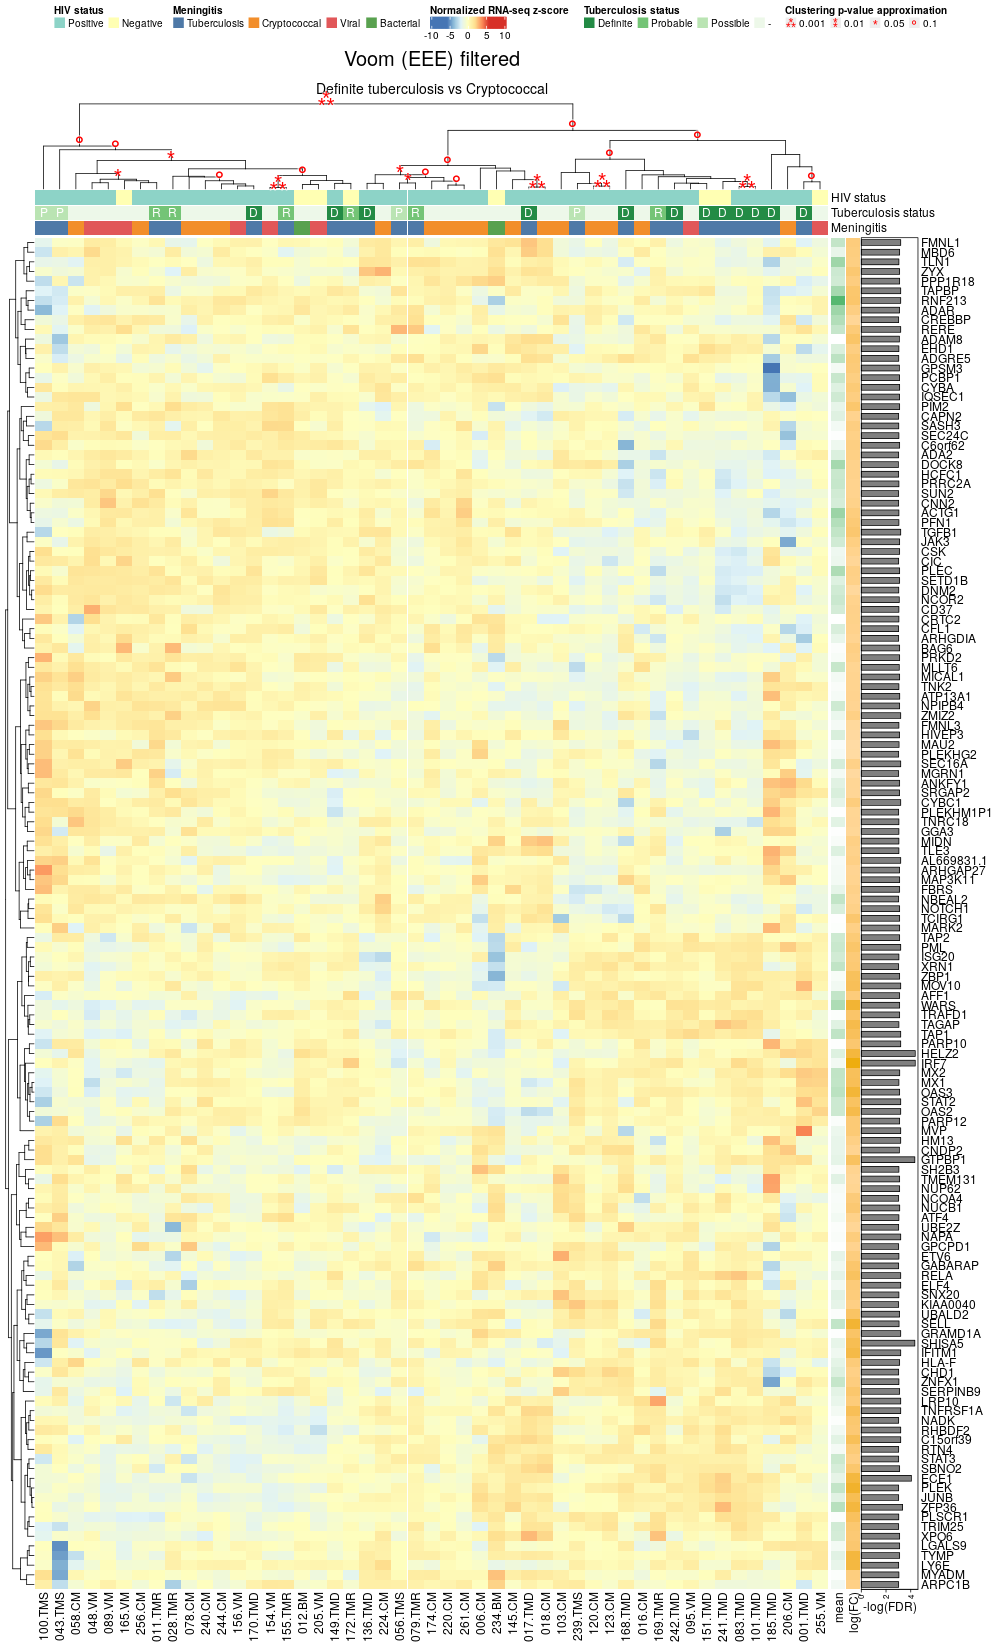

In [481]:
%%R -w 1000 -h 1650 -i voom_filtered_eee

de_heatmap(
    significant.limma(voom_filtered_eee), eee_normalized_tb_subsets,
    major='Voom (EEE) filtered',
    minor='Definite tuberculosis vs Cryptococcal'
)

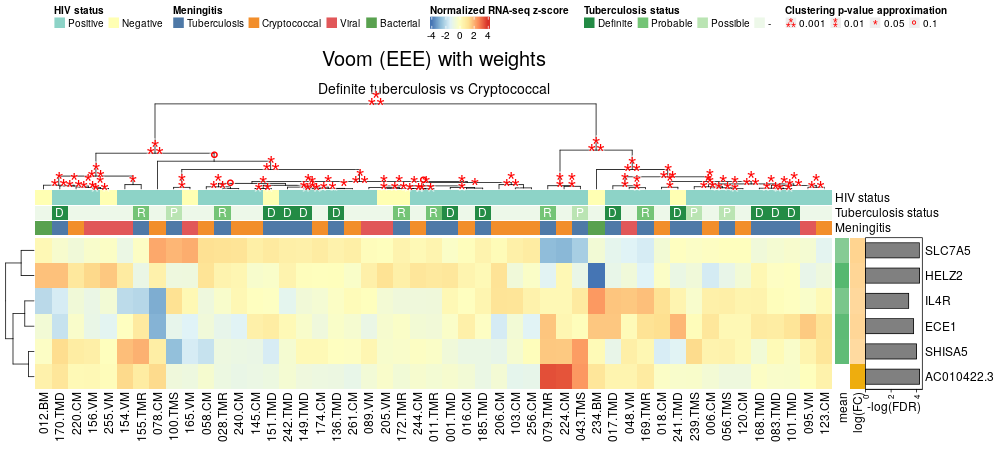

In [473]:
%%R -w 1000 -h 450 -i voom_weighted_eee

de_heatmap(
    significant.limma(voom_weighted_eee), eee_normalized_tb_subsets,
    major='Voom (EEE) with weights',
    minor='Definite tuberculosis vs Cryptococcal'
)

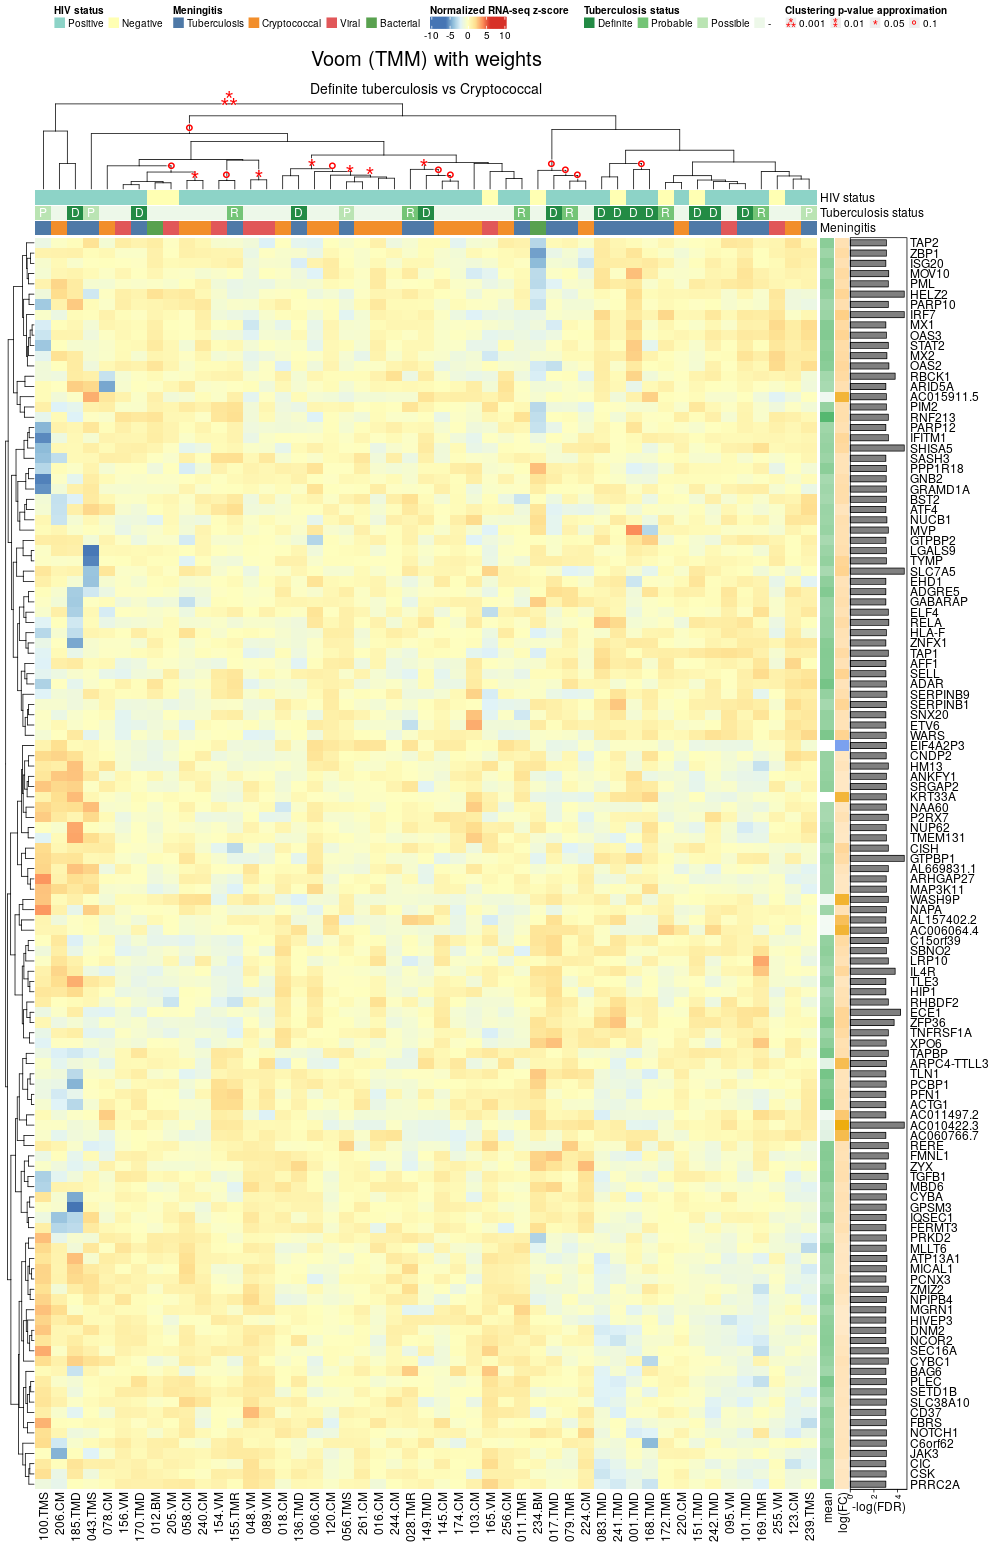

In [463]:
%%R -w 1000 -h 1550 -i voom_weighted_tmm

de_heatmap(
    significant.limma(voom_weighted_tmm), tmm_normalized_tb_subsets,
    major='Voom (TMM) with weights',
    minor='Definite tuberculosis vs Cryptococcal'
)

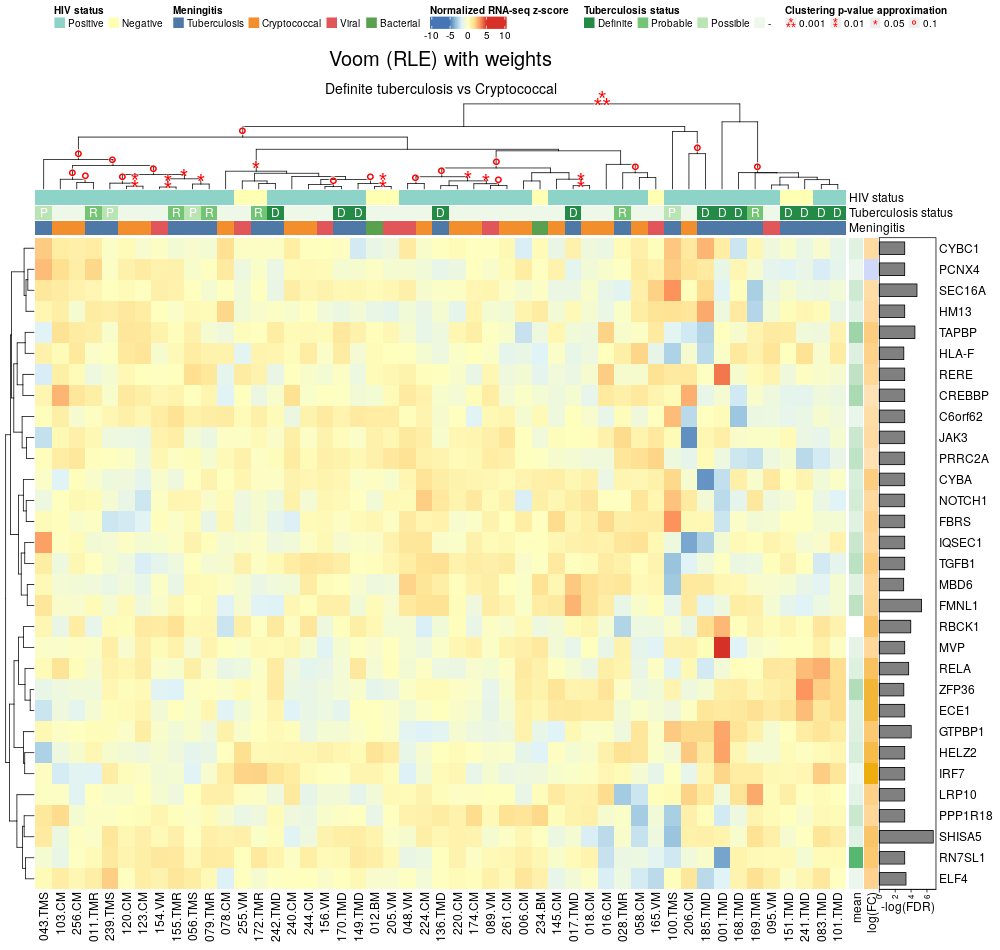

In [1973]:
%%R -w 1000 -h 950 -i voom_weighted_rle

de_heatmap(
    significant.limma(voom_weighted_rle), rle_normalized_tb_subsets,
    major='Voom (RLE) with weights',
    minor='Definite tuberculosis vs Cryptococcal'
)

In [1975]:
provided = reference_definite_tbm_cm_deg

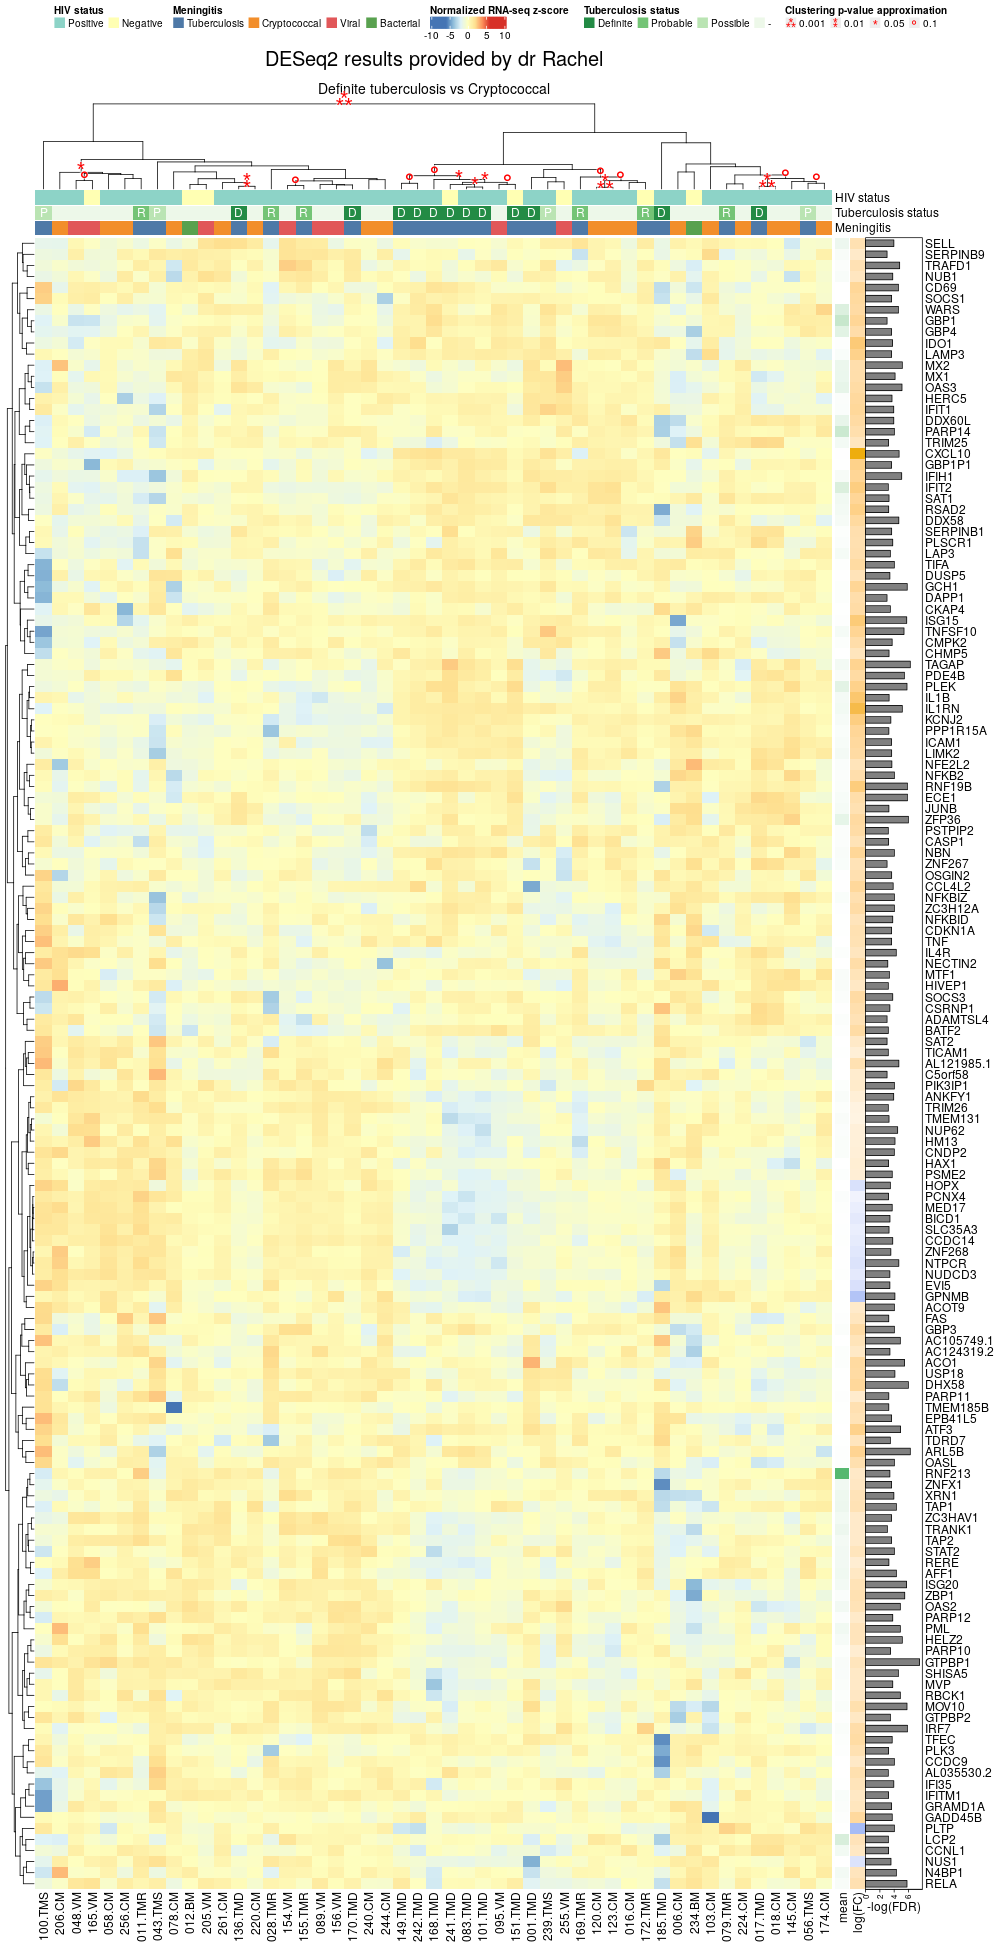

In [1977]:
%%R -w 1000 -h 1950 -i provided
de_heatmap(
    significant.deseq(provided), dds_reproduction,
    major='DESeq2 results provided by dr Rachel',
    minor='Definite tuberculosis vs Cryptococcal'
)

# Final results

I will generate three result sets:
 - voom-TMM
 - DESeq2
 - intersection of voom-TMM and DESeq2

If the number of significant DE genes without independent filtering for voom-TMM will remain as low for other contrasts, I will analyse these by hand as well.

Adding voom-RLE does not seem warranted as the example above shows that it provides little additional results different from voom-TMM; also, the results are expected to be similar to voom-TMM or DESeq2 because it shares large similarities with both of them.

If - as argued by some - the intersection can be restated as a certain percentage of top results of voom-TMM and DESeq2, it would not be a very useful thing to do. But it is not such simple (see paired plot above).

## With TB confidence subsets (definite/probable/possible)

In [221]:
voom_path = Path(results_path) / 'voom_tmm'
voom_path.mkdir(exist_ok=True, parents=True)

In [1876]:
%%R
import::here(collapse_ranking_clusters, .from='helpers/pathways.R')

some_greek_letters = data.frame(
    full=c('alpha', 'beta', 'gamma', 'epsilon'),
    abbreviation=c('\U03B1', '\U03B2', '\U03B3', '\U03B5')
)

collapse_by_clusters_and_topology = function(
    counts, pathways, collection, id_type,
    cluster_p_threshold=0.95,
    counts_transform=log2, damping_factor=0.25,
    nboot=1000, character_limit=100
) {
    pathways_counts = counts_to_pathways_space(counts, collection=collection, id_type=id_type)
    significant_counts = pathways_counts[rownames(pathways),]
    significant_counts = counts_transform(significant_counts + damping_factor)

    bootstrapped_clustering <- pvclust::pvclust(
        t(significant_counts), parallel=T,
        method.hclust="ward.D2", method.dist="correlation",
        nboot=nboot, quiet=T
    )
    highly_probable_clusters <- pvclust::pvpick(bootstrapped_clustering, alpha=cluster_p_threshold)

    cluster_names = names_for_pathway_clusters(
        highly_probable_clusters$clusters, pathways_data=collection, pathways_ranking=pathways,
        abbreviations=some_greek_letters, character_limit=character_limit
    )
    counts_collapsed = collapse_count_clusters(significant_counts, clusters=highly_probable_clusters$clusters, names=cluster_names)

    print(paste(
        'Chosen', length(highly_probable_clusters$clusters),
        'highly probable (p >= ', cluster_p_threshold, ') clusters'
    ))
    
    ranking_collapsed = collapse_ranking_clusters(
        get_significant_pathways(pathways),
        clusters=highly_probable_clusters$clusters,
        names=cluster_names,
        collapse=function(cluster) apply(cluster, 2, min)
    )
    
    list(counts=counts_collapsed, ranking=ranking_collapsed)
}

get_significant_pathways = function(pathways, fdr_threshold=0.05) {
    pathways[pathways$FDR < fdr_threshold,]
}

simple_pheatmap = function(counts_collapsed) {
    pheatmap(
        scale(counts_collapsed),
        show_colnames=T,
        show_rownames=T,
        annotation_col=counts_patient_annotations,
        #annotation_row=annotation_row,
        annotation_colors=patient_colors,
        clustering_method='ward.D2',
        clustering_distance_cols='correlation',
        cluster_rows=T,
        cluster_cols=T,
        scale='row',
        clustering_distance_rows='correlation'
    )
}

In [223]:
%%R
collapsed_voom_reactome_entrez = collapse_by_clusters_and_topology(
    tmm_normalized_tb_subsets, get_significant_pathways(sets_reactome_entrez, 0.01),
    collection=c2.cp.reactome, id_type='entrez',
    # note low bootstrap count and low fdr cutoff (for demonstration purposes)
    nboot=500, character_limit=100
)

[1] "Warning: parent node Signalling to ERKs will not be displayed"             
[2] "Warning: parent node Signalling to RAS will not be displayed"              
[3] "Warning: parent node Prolonged ERK activation events will not be displayed"
[1] "[ARMS-mediated activation | SHC1 events in EGFR signaling | SOS-mediated signalling | Shc Mediated Signalling]"
[2] "RAF/MAP kinase cascade"                                                                                        
[1] "Warning: parent node Signalling to ERKs will not be displayed"             
[2] "Warning: parent node Prolonged ERK activation events will not be displayed"
[1] "[Signalling to RAS | ARMS-mediated activation | SHC1 events in EGFR signaling | SOS-mediated signalling]"
[2] "RAF/MAP kinase cascade"                                                                                  
[1] "Cluster not fully consistent; consistent until 4 position in the FDR-based ranking (40%); consistency = 70%"
[1] "Top 3 pathways in th

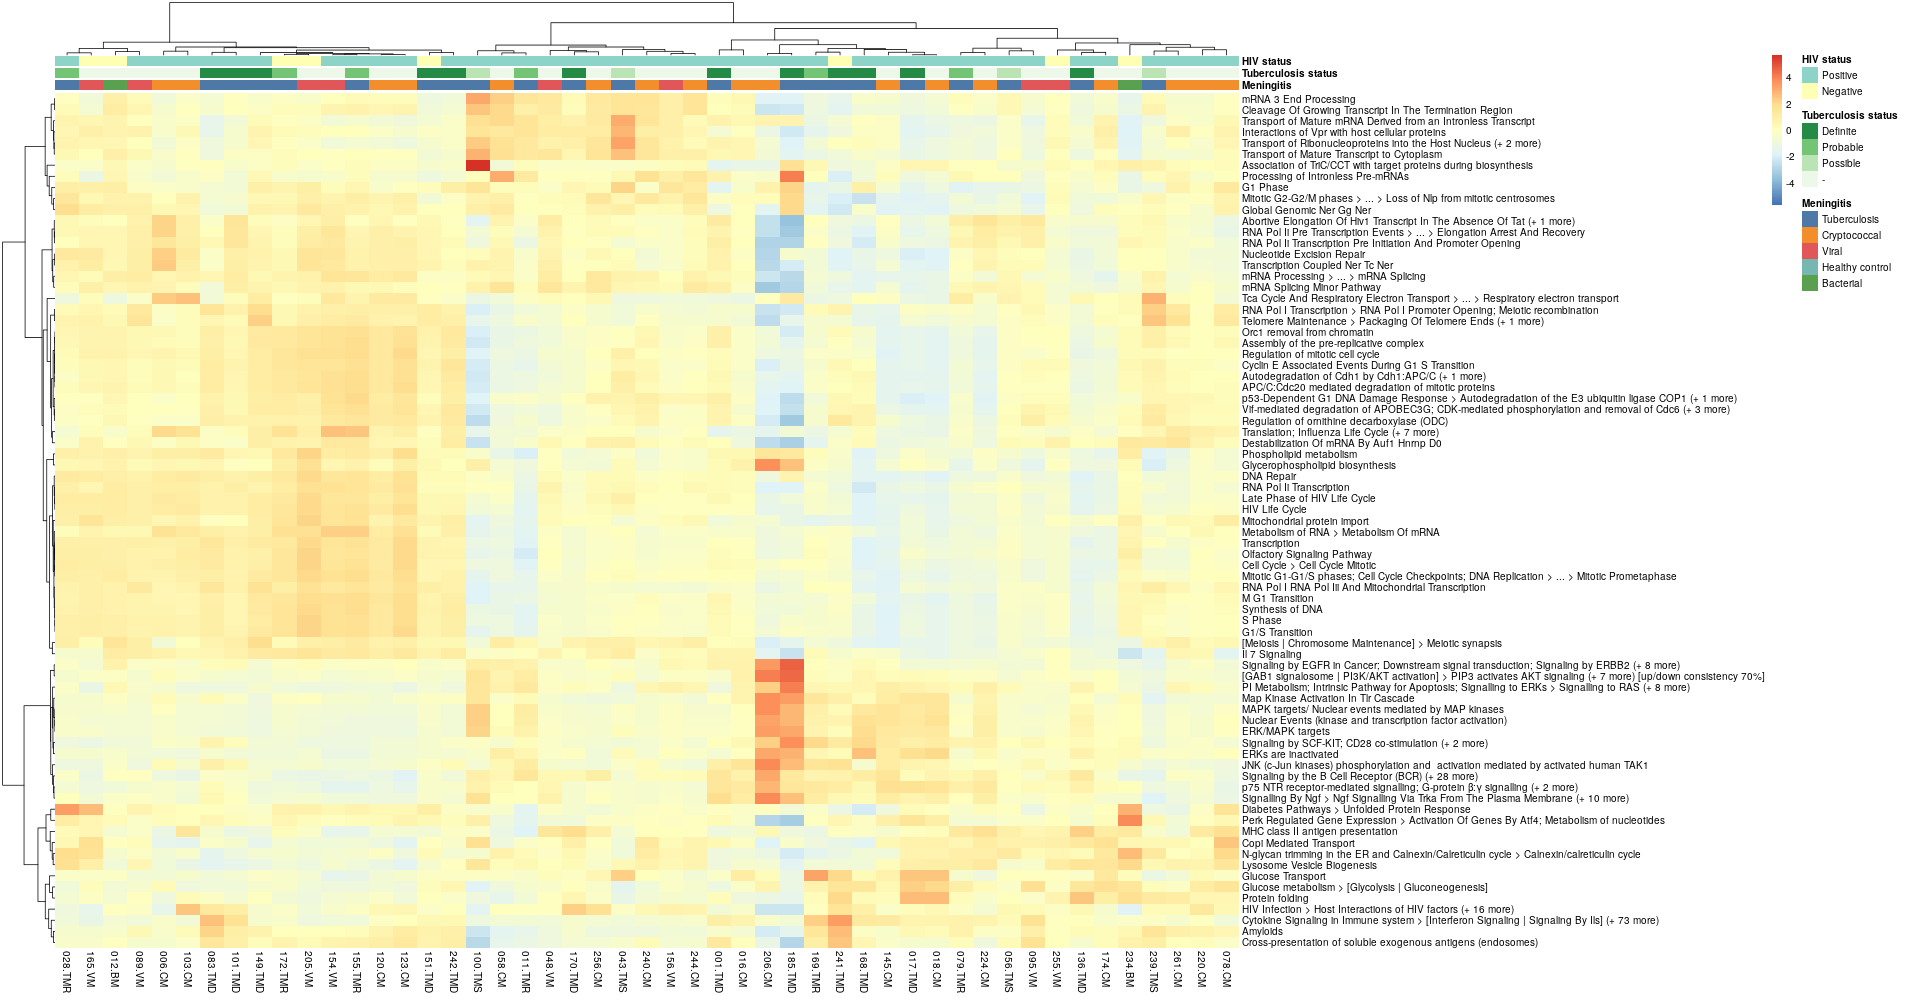

In [225]:
%%R -w 1920 -h 1000
simple_pheatmap(collapsed_voom_reactome_entrez$counts)

Creating a temporary cluster...done:
socket cluster with 7 nodes on host ‘localhost’
Multiscale bootstrap... Done.


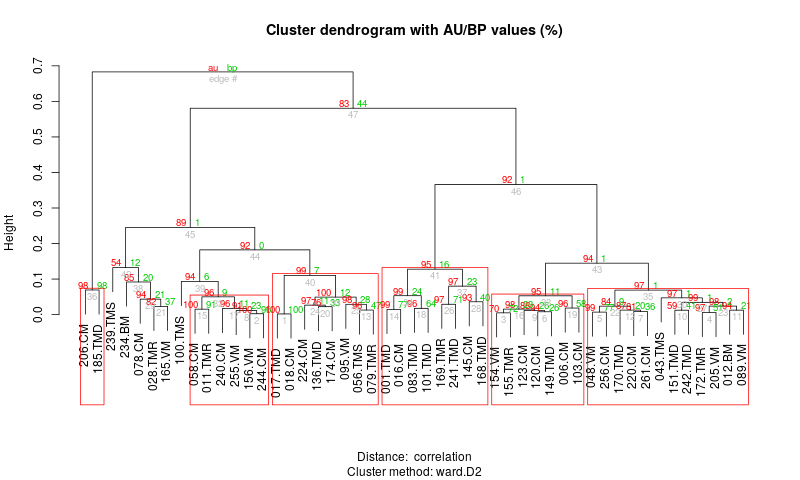

In [226]:
%%R -w 800
collapsed_patients_clustering <- pvclust::pvclust(
    scale(collapsed_voom_reactome_entrez$counts), parallel=T,
    method.hclust="ward.D2", method.dist="correlation"
)
plot(collapsed_patients_clustering)
pvclust::pvrect(collapsed_patients_clustering, alpha=0.95)

Creating a temporary cluster...done:
socket cluster with 7 nodes on host ‘localhost’
Multiscale bootstrap... Done.


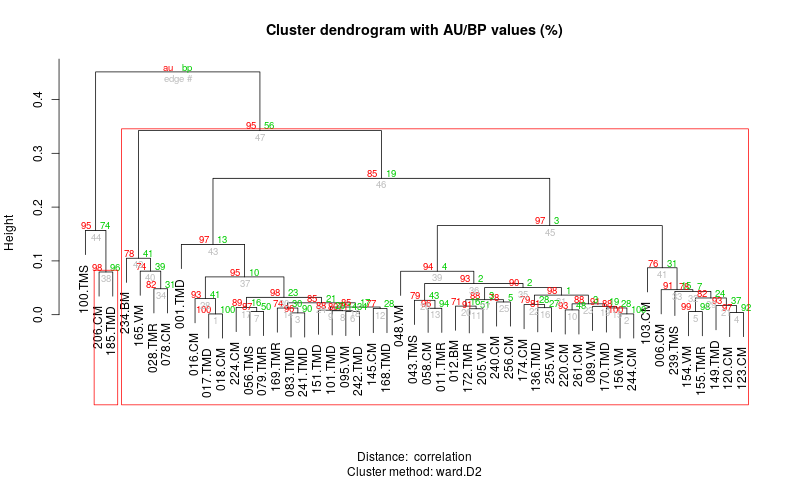

In [227]:
%%R -w 800
significant_counts = pathways_counts[
    rownames(get_significant_pathways(sets_reactome_entrez)),
]

patients_clustering <- pvclust::pvclust(
    scale(significant_counts), parallel=T,
    method.hclust="ward.D2", method.dist="correlation"
)
plot(patients_clustering)
pvclust::pvrect(patients_clustering, alpha=0.95)

In [1884]:
%%R
import::here(pvclust_heatmap, simple_clinical_annotation, .from='plots/complex_heatmap.R')

full_pathways_plot = function(counts_collapsed, pathways_collapsed, samples_clustering, main=NULL, major=NULL, minor=NULL) {
    title = compose_title(main, major, minor)
    pvclust_heatmap(
        counts_collapsed, samples_clustering, title,
        right_annotation=ComplexHeatmap::rowAnnotation(
            '-log(min(FDR))'=ComplexHeatmap::anno_barplot(
                -log(pathways_collapsed[,'FDR']),
                axis_param=list(side ='bottom'),
                width = unit(2, "cm")
            )
        ),
        column_names_rot=45,
    )
}

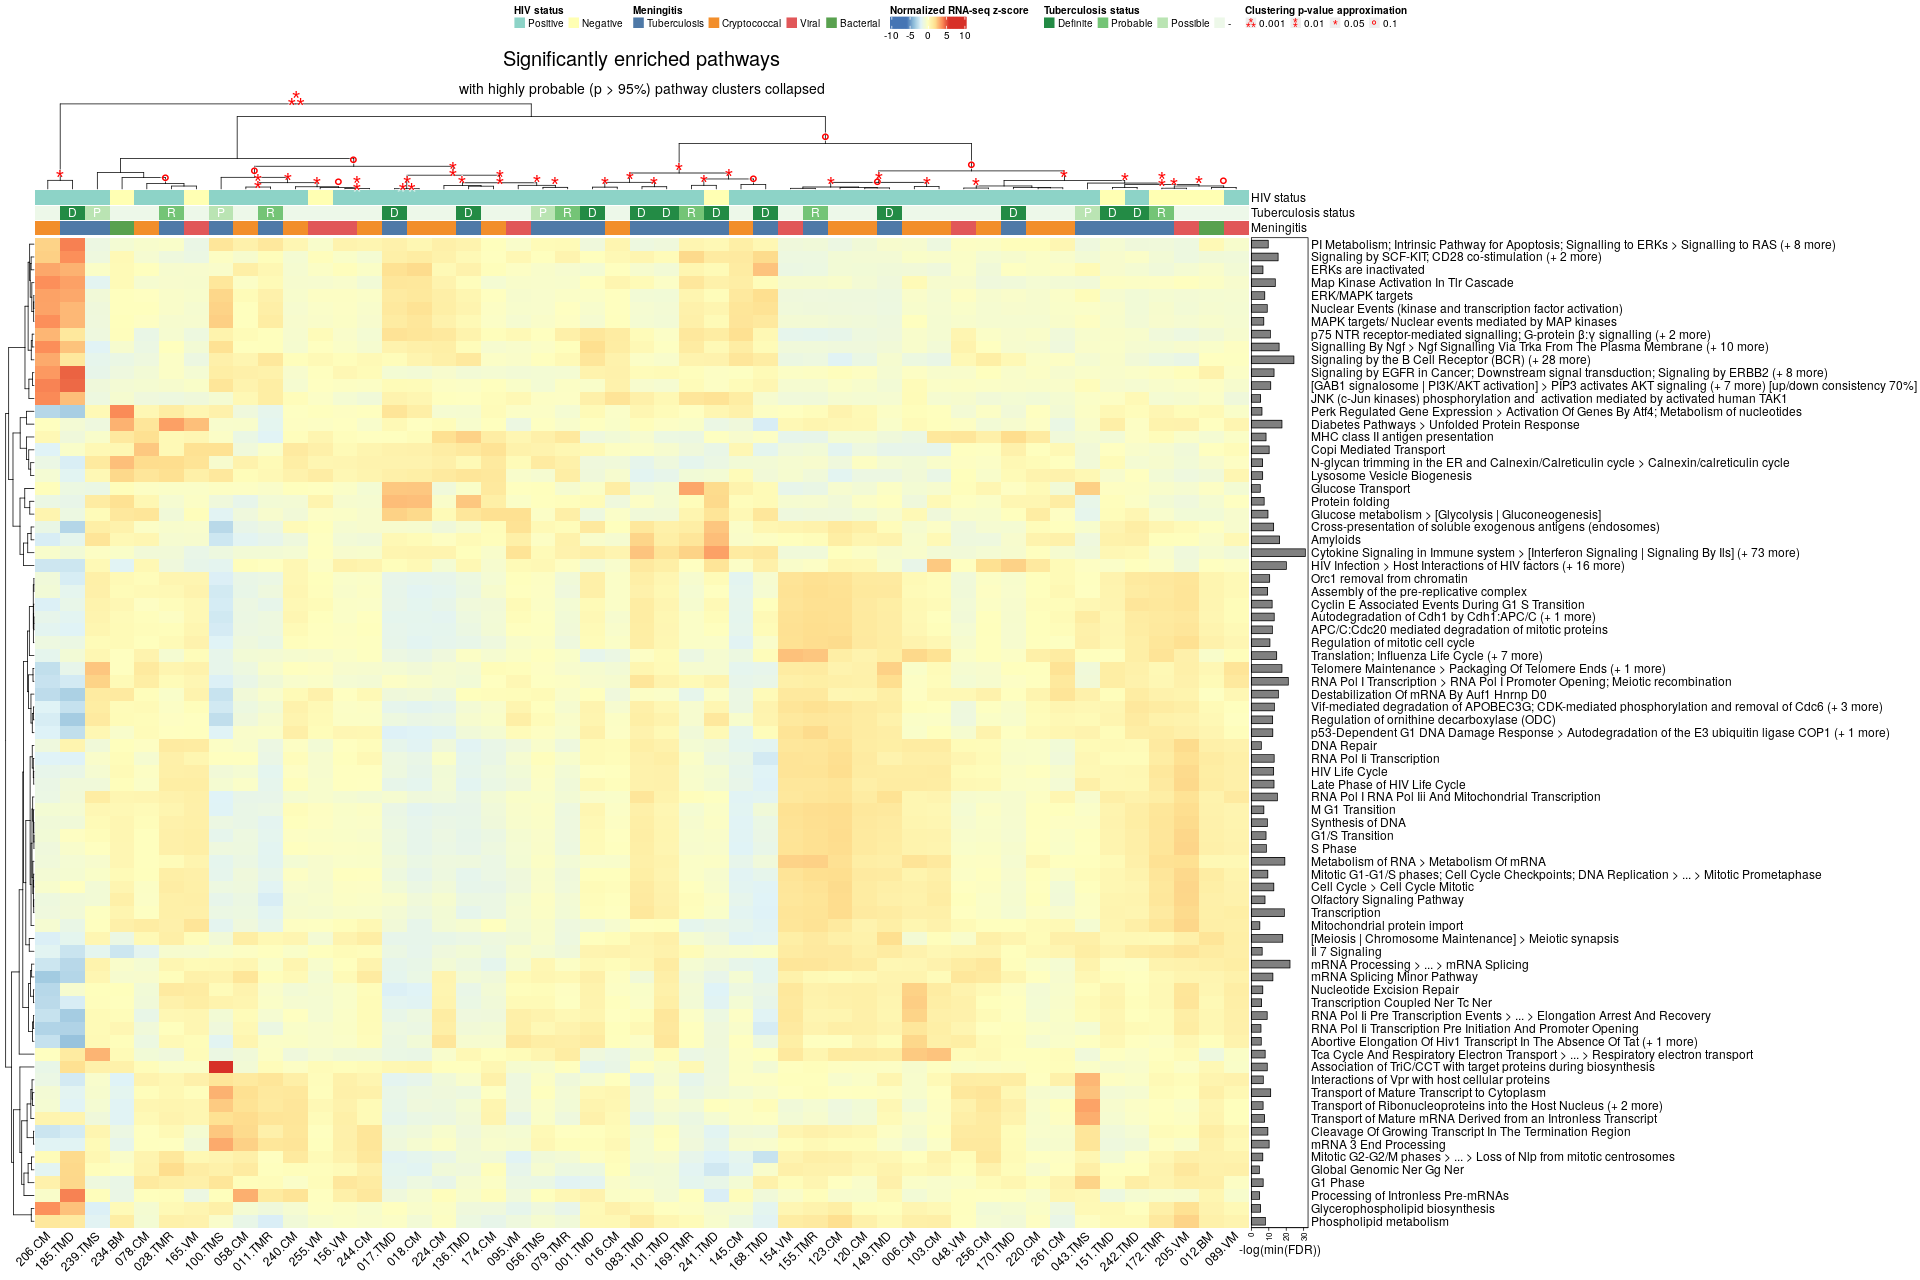

In [229]:
%%R -w 1920 -h 1280

full_pathways_plot(
    collapsed_voom_reactome_entrez$counts,
    pathways_collapsed=collapsed_voom_reactome_entrez$ranking,
    samples_clustering=collapsed_patients_clustering,
    major='Significantly enriched pathways',
    minor='with highly probable (p > 95%) pathway clusters collapsed'
)

In [1468]:
%%R
import::here(average_pathways_expression, .from='helpers/pathways.R')

In [1477]:
%%R
save_plot = function(plot, path, width=800, height=1000, units='px', device=png, ...) {
    dev.off()
    device(path, width=width, height=height, units=units)
    plot()    
}

run_limma_pathways_analysis = function(
    a, b,
    with_de_params, collection, id_type, analysis_name, contrast_id, counts, contrast_samples, out_path,
    include_filtered=T, collapse_pathways=FALSE
) {
    
    analysis_id = tolower(sub(' ', '_', analysis_name))
    
    path = paste0(out_path, 'pathways/')
    dir.create(file.path(out_path, 'pathways'), showWarnings = FALSE)

    dir.create(file.path(path, analysis_id), showWarnings = FALSE)
    path = paste0(path, analysis_id, '/')
    
    # this uses standard t-statistic, so no effect from the independent weighting
    voom_de_gene_sets = with_de_params(calc_camera, collection=collection, convert_to=id_type)
    
    voom_de_gene_sets$AveExpr = average_pathways_expression(
        counts, collection=collection, id_type,
        pathways_subset=rownames(voom_de_gene_sets),
    )
    write.csv(voom_de_gene_sets, paste0(path, analysis_id, '_', contrast_id, '.csv'))

    if(include_filtered) {   
        voom_de_gene_sets_filtered = add_p_value_for_filtered_subset(voom_de_gene_sets, fdr_threshold=0.05, expression_col='AveExpr', pvalue_col='PValue')
        write.csv(voom_de_gene_sets_filtered, paste0(path, analysis_id, '_pathways_filtered-', contrast_id, '.csv'))
    }
    
    top_pathways_heatmap = save_plot(
        plot=function() { gene_set_heatmap(
            head(voom_de_gene_sets, 50), counts, collection=collection, id_type=id_type,
            main=paste0(a, ' - ', b, ' top 50 pathways, showing all samples (', analysis_name, ', voom)'),
            trim=55
        ) },
        path=paste0(path, analysis_id, '_top_50_heatmap-', contrast_id, '.png'),
        width=900*1.2, height=1200*1.2
    )
    
    analysed_patients = names(contrast_samples[!contrast_samples])
    
    top_pathways_heatmap_analysed_contrast_only = save_plot(
        plot=function() { gene_set_heatmap(
            head(voom_de_gene_sets, 50), counts, collection=collection, id_type=id_type,
            main=paste0(a, ' - ', b, ' top 50 pathways (', analysis_name, ', voom)'),
            trim=55, skip_cols=c(outliers, analysed_patients)
        ) },
        path=paste0(path, analysis_id, '_top_50_heatmap-analysed_contrast_only-', contrast_id, '.png'),
        width=900*1.2, height=1200*1.2
    )
    
    pathways_counts = counts_to_pathways_space(counts, collection=collection, id_type=id_type)
    significant_counts = pathways_counts[rownames(get_significant_pathways(voom_de_gene_sets)),]
    significant_counts = log2(significant_counts + 0.25)
    
    if (nrow(significant_counts) == 0) {
        print(paste('Skipping: no significant pathways for', a, '-', b, analysis_name))
        return(NULL)
    }
    
    # more conservative
    patients_clustering <- pvclust::pvclust(
        scale(significant_counts), parallel=T,
        method.hclust="ward.D2", method.dist="correlation"
    )

    # better for full reactome which has a high degree of pathways redundance
    # but if may cluster too much sometimes
    #unbiased_patients_clustering <- pvclust::pvclust(
    #    scale(counts_collapsed), parallel=T,
    #    method.hclust="ward.D2", method.dist="correlation"
    #)

    save_plot(
        plot=function(){
            plot(
                patients_clustering,
                main=paste0(a, ' - ', b, ' based on significant pathways (', analysis_name, ', voom)')
            )
            pvclust::pvrect(patients_clustering, alpha=0.95)
        },
        path=paste0(path, analysis_id, '_based_clustering-', contrast_id, '.png'),
        width=900*1.2, height=500*1.2
    )
    
    if(collapse_pathways) {
        collapsed = collapse_by_clusters_and_topology(
            counts, get_significant_pathways(voom_de_gene_sets, 0.01),
            collection=collection, id_type=id_type,
            nboot=1000
        )
        save_plot(
            plot=function() {
                full_pathways_plot(
                    collapsed$counts,
                    pathways_collapsed=collapsed$ranking,
                    samples_clustering=patients_clustering,
                    major=paste0(a, ' - ', b, ' significant ($FDR < 0.01$) pathways (', analysis_name, ', voom)'),
                    minor='with highly probable ($p > 95%$) pathway clusters collapsed, showing all samples'
                )
            },
            path=paste0(path, analysis_id, '_heatmap-', contrast_id, '.png'),
            width=1920, height=250 + 15 * nrow(collapsed$counts)
        )

        skip_cols=c(outliers, analysed_patients)
        significant_counts = significant_counts[,!(colnames(significant_counts) %in% skip_cols)]
        counts = counts[,!(colnames(counts) %in% skip_cols)]
        patients_clustering <- pvclust::pvclust(
            scale(significant_counts), parallel=T,
            method.hclust="ward.D2", method.dist="correlation"
        )
        collapsed = collapse_by_clusters_and_topology(
            counts, get_significant_pathways(voom_de_gene_sets, 0.01),
            collection=collection, id_type=id_type,
            nboot=1000
        )
        
        save_plot(
            plot=function() {
                full_pathways_plot(
                    collapsed$counts,
                    pathways_collapsed=collapsed$ranking,
                    samples_clustering=patients_clustering,
                    major=paste0(a, ' - ', b, ' significant ($FDR < 0.01$) pathways (', analysis_name, ', voom)'),
                    minor='with highly probable ($p > 95%$) pathway clusters collapsed'
                )
            },
            path=paste0(path, analysis_id, '_heatmap-analysed_contrast_only-', contrast_id, '.png'),
            width=1920, height=250 + 15 * nrow(collapsed$counts)
        )
        
    }

}

In [1485]:
%%R

run_pairwise_de_analyses = function(conditions, normalization, out_path, ...) {
    # TODO: redirect output to a log file
    dir.create(file.path(out_path), showWarnings = FALSE)

    normalized_tb_subsets = preprocess_limma(
        raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers,
        'Definite tuberculosis', method=normalization, ...
    )
    nm = normalization
    
    combinations = combn(conditions, 2, simplify=F)
    i = 0

    for(combination in combinations) {
        print(paste0('Progress: ', 100 * i / length(combinations), '%'))
        i = i + 1

        a = combination[1]
        b = combination[2]

        contrast_samples = by_condition_and_tb_subset_no_outliers == a | by_condition_and_tb_subset_no_outliers == b
        skip_cols = c(outliers, names(contrast_samples[!contrast_samples]))

        contrast_id = paste(a, b, sep='_vs_')

        # voom with quality sample weights, robust, TMM normalization
        # outlier samples defined as |z-score| > 2 removed,
        # independent weighting of hypotheses with IHW using mean expression as the independent hypothesis

        with_de_params = function(func, ...) {
            func(a, b, normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T, ...)
        }

        voom_de = with_de_params(calc_de, confint=T)
        voom_de = add_p_value_for_weighted_hypothesis(voom_de)

        path = paste0(out_path, 'genes/')
        dir.create(file.path(out_path, 'genes'), showWarnings = FALSE)

        write.csv(voom_de, paste0(path, 'voom-', contrast_id, '.csv'))

        significant_count = nrow(significant.limma(voom_de))
        print(significant_count)

        significant_genes_heatmap = save_plot(
            plot=function() {
                de_heatmap(
                    significant.limma(voom_de), normalized_tb_subsets,
                    major=paste(a, '-', b, 'limma-voom differentially expressed genes'),
                    minor=paste0(nm, ', quality weights, robust, IHW $FDR<0.05$, showing all samples')
                )
            },
            path=paste0(path, 'heatmap-', contrast_id, '.png'),
            width=1000, height=250 + 15 * significant_count
        )

        significant_genes_heatmap_analysed_contrast_only = save_plot(
            plot=function() {
                de_heatmap(
                    significant.limma(voom_de), normalized_tb_subsets,
                    major=paste(a, '-', b, 'limma-voom differentially expressed genes'),
                    minor=paste0(nm, ', quality weights, robust, IHW $FDR<0.05$'),
                    skip_cols=c(outliers, names(contrast_samples[!contrast_samples]))
                )
            },
            path=paste0(path, 'heatmap-analysed_contrast_only-', contrast_id, '.png'),
            width=1000, height=250 + 15 * significant_count
        )


        # Pathways for msigdb
        run_limma_pathways_analysis(
            a, b,
            with_de_params, contrast_id=contrast_id, counts=normalized_tb_subsets, contrast_samples=contrast_samples,
            analysis_name='MSigDB Reactome', collection=c2.cp.reactome, id_type='entrez',
            collapse_pathways=TRUE, out_path=out_path
        )

        # Same but for full Reactome
        run_limma_pathways_analysis(
            a, b,
            with_de_params, contrast_id=contrast_id, counts=normalized_tb_subsets, contrast_samples=contrast_samples,
            analysis_name='Full Reactome', collection=reactome_new_symbol, id_type='symbol',
            out_path=out_path
        )
    }
}

In [1886]:
%%R -i results_path

voom_path = paste0(results_path, 'qtotal_tmm_no_scale/')
run_pairwise_de_analyses(
    c('Definite tuberculosis', 'Cryptococcal'),
    'qtotal',
    voom_path,
    rescale_lib=F,
    rescale_factor=F
)

[1] "Retaining: 59.29%"
[1] "Progress: 0%"
[1] 123
Creating a temporary cluster...done:
socket cluster with 7 nodes on host ‘localhost’
Multiscale bootstrap... Done.
[1] "Cluster not fully consistent; consistent until 18 position in the FDR-based ranking (52.94%); consistency = 94.12%"
[1] "Top 3 pathways in the inconsistent cluster:"
                                                     NGenes Direction
Signaling by the B Cell Receptor (BCR)                  118        Up
Downstream signaling events of B Cell Receptor (BCR)     90        Up
Apoptosis                                               139        Up
                                                           PValue          FDR
Signaling by the B Cell Receptor (BCR)               1.402173e-08 5.529996e-07
Downstream signaling events of B Cell Receptor (BCR) 3.116112e-08 1.045456e-06
Apoptosis                                            3.045993e-07 6.011357e-06
                                                         AveExpr
Si

In [ ]:
%%R -i results_path
stop('This analysis step takes too long to be included in automated builds')

conditions = unique(by_condition_and_tb_subset_no_outliers)

voom_path = paste0(results_path, 'voom_tmm/')
run_pairwise_de_analyses(conditions, 'TMM', voom_path)

Notes:
 - mRNA processing is highly correlated with HIV life cycle

## With aggregated TB samples

TODO

TODO: re-run protein!

TODO: recall citation for the fact that limma-trend gets less significant results and it is ok and what it means.